In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm

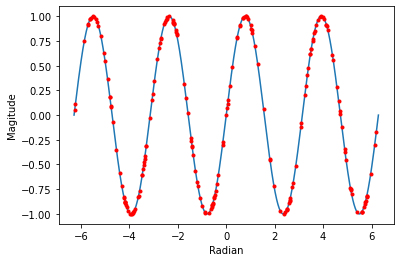

In [ ]:
x_train = np.atleast_2d(np.linspace(-2*np.pi, 2*np.pi, 1000)).T
x_val = np.atleast_2d(np.random.uniform(-2*np.pi, 2*np.pi, 200)).T
y_train = np.atleast_2d(np.sin(2*x_train))
y_val = np.atleast_2d(np.sin(2*x_val))
plt.plot(x_train, y_train, '-')
plt.plot(x_val, np.sin(2*x_val), '.', c='r')
plt.xlabel('Radian')
plt.ylabel('Magitude')
plt.show()

In [ ]:
class Regression(nn.Module):
    def __init__(self,num_in,num_hidden,num_out):
        super(Regression, self).__init__()
        
        self.fc1 =  nn.Linear(num_in, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, num_out)
        

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x

In [ ]:
train_set = np.concatenate([x_train, y_train], axis=1)
print(train_set.shape)
print(len(train_set))

val_set = np.concatenate([x_val, y_val], axis=1)
print(train_set.shape)
#val_set_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


(1000, 2)
1000
(1000, 2)


In [ ]:
'''
reg_lambda=0.01
l2_reg = 0
    if isinstance(layer_names, list):
         for W in self.model.named_parameters():
             if "weight" in W[0]:
                 layer_name = W[0].replace(".weight", "")
                 if layer_name in layer_names:
                     l2_reg = l2_reg + W[1].norm(2)
loss = loss + l2_reg * reg_lambda
loss.backward()
'''

'\nreg_lambda=0.01\nl2_reg = 0\n    if isinstance(layer_names, list):\n         for W in self.model.named_parameters():\n             if "weight" in W[0]:\n                 layer_name = W[0].replace(".weight", "")\n                 if layer_name in layer_names:\n                     l2_reg = l2_reg + W[1].norm(2)\nloss = loss + l2_reg * reg_lambda\nloss.backward()\n'

In [ ]:
def train(train_set, batch_size, num_epochs, learning_rate, model):

    train_set_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    no_batches = int(np.round((len(train_set) / batch_size)))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

    losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_set_loader:
            #print(data.shape)
            x, y = data[:, 0], data[:, 1]
            #print(type(x), x.shape)
            x = x.view(batch_size, 1)
            #print('x ', x.shape)
            y = y.view(batch_size, 1)
            #print('y ', y.shape)
            output = model(x.float())
            #print('output ', output.shape)
            loss = criterion(output, y.float())
            #print('loss ', loss)
          
            # grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
            # print('grad', grad[0])
            # for W in model.parameters():
            #   #print(W.data)
            #   #a = 
            #   # print(W.norm(1))
            #   loss = loss + W.norm(2)
            
            #grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
            #print('grad', grad)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() 
            #aa =bb
        if epoch % 1000 == 0:    
          print('====> Epoch: {} Average loss: {:.4f}'.format(
                epoch, train_loss / no_batches))
        losses.append(train_loss / no_batches) 

    weights = []
    for w in model.parameters():
      weights.append(w.detach().numpy())
    return weights

def evaluate_test(test_set,  batch_size, model):
    
    test_loss = 0
    criterion = nn.MSELoss()
    test_no_batches = np.round(int(len(test_set)/batch_size))

    test_set_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    output_lst = []
    
    for data in test_set_loader:
            x, y = data[:, 0], data[:, 1]
            # print(type(x), x.shape)
            x = x.view(batch_size, 1)
            #print('x ', x.shape)
            y = y.view(batch_size, 1)

            output = model(x.float())

            temp = output.detach().numpy()
            temp = list(temp)
            output_lst = output_lst + temp

            loss = criterion(output, y.float())
            test_loss += loss.item()
    print(len(output_lst))       
        # =================== log ========================
    test_loss = test_loss/test_no_batches
    print('====> Test loss: {:.4f}'.format(test_loss))
    return output_lst

def visualizeData(item, model):
  
  attribute = item[0]
  weights = item[1]
  x = item[2]
  y = item[3]
  print('Amplitude A={}, Frequency f={}, phase={}pi'.format(attribute[0], attribute[1], attribute[2]/np.pi))
  
  for param_cur, param_best in zip(model.parameters(), weights):
    temp = torch.from_numpy(param_best)
    param_cur.data = temp.data
  
  val_set = np.concatenate([x, y], axis=1)
  yhat = evaluate_test(val_set,  100, model)
  plt.plot(x, yhat, '.', c='r')
  plt.xlabel('Radian')
  plt.ylabel('Magitude')
  plt.show()

====> Epoch: 0 Average loss: 0.5210
====> Epoch: 1000 Average loss: 0.0681
====> Epoch: 2000 Average loss: 0.0443
====> Epoch: 3000 Average loss: 0.0375
====> Epoch: 4000 Average loss: 0.0367
====> Epoch: 5000 Average loss: 0.0362
200
====> Test loss: 0.0334


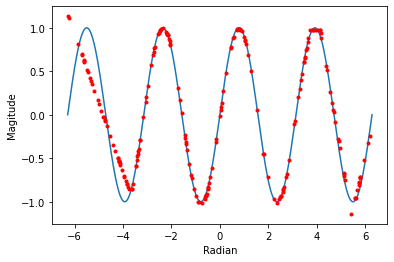

In [ ]:
num_in = 1
num_hidden = 40
num_out = 1

model = Regression(num_in,num_hidden,num_out)
fitted_parameter = train(train_set, 100, 6000, 1e-4, model)

yhat = evaluate_test(val_set,  100, model)

# yhat = model(x_val)
plt.plot(x_train, y_train, '-')
plt.plot(x_val, yhat, '.', c='r')
plt.xlabel('Radian')
plt.ylabel('Magitude')
plt.show()

6
6
Amplitude A=1, Frequency f=2, phase=0.0pi
200
====> Test loss: 0.0334


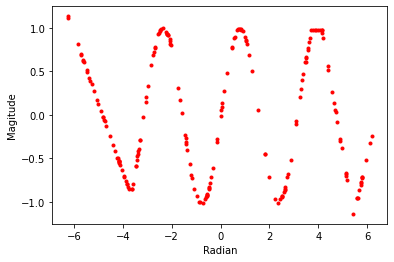

In [ ]:
print(len(fitted_parameter))
model_new = Regression(num_in,num_hidden,num_out)
attribute = [1,2,0]
weight = list(fitted_parameter)
print(len(weight))
item = (attribute, weight, x_val, y_val)
visualizeData(item, model_new)

In [ ]:
# for i in fitted_parameter:
#   print(i)

In [ ]:
class SineWaveGenerator():
  def __init__(self, regressor):

    self.A_lst = np.arange(0.4, 2.01, 0.2)
    #self.phase_lst = [0]
    self.phase_lst = np.arange(0, 2*np.pi, np.pi/8)
    self.f_lst = np.arange(0.8, 1.01, 0.2)

    self.regressor = regressor
    # self.early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=0, patience=500)
    
    self.rangeLow = -2*np.pi
    self.rangeHigh = 2*np.pi

    #model specification
    self.num_in = 1
    self.num_hidden = 40
    self.num_out = 1

    self.x = np.atleast_2d(np.linspace(self.rangeLow, self.rangeHigh, 1000)).T
    self.x_val = np.atleast_2d(np.random.uniform(-2*np.pi, 2*np.pi, 200)).T


  def GenDataset(self):
    attributes_lst = list(itertools.product(self.A_lst, self.f_lst, self.phase_lst))
    
    data_lst = []
    for attribute in tqdm.tqdm(attributes_lst):
      MyModel = self.regressor(self.num_in,self.num_hidden,self.num_out)
      y_train = np.atleast_2d(attribute[0]*np.sin(attribute[1]*x_train+attribute[2]))
      train_set = np.concatenate([x_train, y_train], axis=1)

      weight = train(train_set, 100, 6000, 1e-5, MyModel)

      y_val = np.atleast_2d(attribute[0]*np.sin(attribute[1]*self.x_val+attribute[2]))
      val_set = np.concatenate([self.x_val, y_val], axis=1)
      yhat = evaluate_test(val_set,  100, MyModel)

      cur_data = (attribute, weight, self.x_val, yhat)
      data_lst.append(cur_data)
    
    with open("sineWave_xxl.p", 'wb') as f:
      pickle.dump((data_lst), f, protocol=2)
    
    return data_lst

  
  
      

In [ ]:
try:
  filename = 'sineWave_xxl.p'
  with open(filename, 'rb') as f:
      train_dataset = pickle.load(f)
except:  
  sin = SineWaveGenerator(Regression)
  train_dataset = sin.GenDataset()

  0%|          | 0/288 [00:00<?, ?it/s]

====> Epoch: 0 Average loss: 0.1596
====> Epoch: 1000 Average loss: 0.0010
====> Epoch: 2000 Average loss: 0.0005
====> Epoch: 3000 Average loss: 0.0002
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0001


  0%|          | 1/288 [01:57<9:22:36, 117.62s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2841
====> Epoch: 1000 Average loss: 0.0025
====> Epoch: 2000 Average loss: 0.0006
====> Epoch: 3000 Average loss: 0.0003
====> Epoch: 4000 Average loss: 0.0002
====> Epoch: 5000 Average loss: 0.0001


  1%|          | 2/288 [04:00<9:28:42, 119.31s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2353
====> Epoch: 1000 Average loss: 0.0049
====> Epoch: 2000 Average loss: 0.0013
====> Epoch: 3000 Average loss: 0.0005
====> Epoch: 4000 Average loss: 0.0002
====> Epoch: 5000 Average loss: 0.0001


  1%|          | 3/288 [05:59<9:25:28, 119.05s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0561
====> Epoch: 1000 Average loss: 0.0108
====> Epoch: 2000 Average loss: 0.0013
====> Epoch: 3000 Average loss: 0.0001
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  1%|▏         | 4/288 [08:02<9:29:32, 120.33s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.4545
====> Epoch: 1000 Average loss: 0.0070
====> Epoch: 2000 Average loss: 0.0004
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  2%|▏         | 5/288 [10:05<9:31:33, 121.18s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0987
====> Epoch: 1000 Average loss: 0.0063
====> Epoch: 2000 Average loss: 0.0004
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  2%|▏         | 6/288 [12:14<9:39:50, 123.37s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0930
====> Epoch: 1000 Average loss: 0.0062
====> Epoch: 2000 Average loss: 0.0012
====> Epoch: 3000 Average loss: 0.0003
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


  2%|▏         | 7/288 [14:24<9:46:58, 125.33s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2923
====> Epoch: 1000 Average loss: 0.0019
====> Epoch: 2000 Average loss: 0.0008
====> Epoch: 3000 Average loss: 0.0005
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0003


  3%|▎         | 8/288 [16:33<9:50:32, 126.54s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.2626
====> Epoch: 1000 Average loss: 0.0008
====> Epoch: 2000 Average loss: 0.0004
====> Epoch: 3000 Average loss: 0.0002
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


  3%|▎         | 9/288 [18:41<9:49:56, 126.87s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1168
====> Epoch: 1000 Average loss: 0.0007
====> Epoch: 2000 Average loss: 0.0003
====> Epoch: 3000 Average loss: 0.0002
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0001


  3%|▎         | 10/288 [20:53<9:55:22, 128.50s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0790
====> Epoch: 1000 Average loss: 0.0036
====> Epoch: 2000 Average loss: 0.0005
====> Epoch: 3000 Average loss: 0.0001
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  4%|▍         | 11/288 [23:01<9:52:26, 128.33s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.5922
====> Epoch: 1000 Average loss: 0.0159
====> Epoch: 2000 Average loss: 0.0033
====> Epoch: 3000 Average loss: 0.0005
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


  4%|▍         | 12/288 [25:15<9:58:45, 130.16s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0921
====> Epoch: 1000 Average loss: 0.0072
====> Epoch: 2000 Average loss: 0.0003
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  5%|▍         | 13/288 [27:23<9:52:38, 129.30s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1341
====> Epoch: 1000 Average loss: 0.0098
====> Epoch: 2000 Average loss: 0.0014
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


  5%|▍         | 14/288 [29:28<9:44:33, 128.01s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0978
====> Epoch: 1000 Average loss: 0.0050
====> Epoch: 2000 Average loss: 0.0012
====> Epoch: 3000 Average loss: 0.0004
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


  5%|▌         | 15/288 [31:28<9:32:39, 125.86s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1659
====> Epoch: 1000 Average loss: 0.0018
====> Epoch: 2000 Average loss: 0.0011
====> Epoch: 3000 Average loss: 0.0006
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0002


  6%|▌         | 16/288 [33:28<9:21:54, 123.95s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.1081
====> Epoch: 1000 Average loss: 0.0146
====> Epoch: 2000 Average loss: 0.0087
====> Epoch: 3000 Average loss: 0.0041
====> Epoch: 4000 Average loss: 0.0015
====> Epoch: 5000 Average loss: 0.0005


  6%|▌         | 17/288 [35:28<9:14:38, 122.80s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.0985
====> Epoch: 1000 Average loss: 0.0110
====> Epoch: 2000 Average loss: 0.0035
====> Epoch: 3000 Average loss: 0.0009
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0001


  6%|▋         | 18/288 [37:31<9:12:17, 122.73s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.0771
====> Epoch: 1000 Average loss: 0.0157
====> Epoch: 2000 Average loss: 0.0044
====> Epoch: 3000 Average loss: 0.0022
====> Epoch: 4000 Average loss: 0.0019
====> Epoch: 5000 Average loss: 0.0015


  7%|▋         | 19/288 [39:26<8:59:45, 120.39s/it]

200
====> Test loss: 0.0014
====> Epoch: 0 Average loss: 0.1402
====> Epoch: 1000 Average loss: 0.0071
====> Epoch: 2000 Average loss: 0.0008
====> Epoch: 3000 Average loss: 0.0006
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0004


  7%|▋         | 20/288 [41:23<8:54:12, 119.60s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 0.1424
====> Epoch: 1000 Average loss: 0.0067
====> Epoch: 2000 Average loss: 0.0003
====> Epoch: 3000 Average loss: 0.0003
====> Epoch: 4000 Average loss: 0.0002
====> Epoch: 5000 Average loss: 0.0002


  7%|▋         | 21/288 [43:24<8:53:20, 119.85s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.4034
====> Epoch: 1000 Average loss: 0.0138
====> Epoch: 2000 Average loss: 0.0008
====> Epoch: 3000 Average loss: 0.0006
====> Epoch: 4000 Average loss: 0.0005
====> Epoch: 5000 Average loss: 0.0004


  8%|▊         | 22/288 [45:27<8:55:32, 120.80s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.1145
====> Epoch: 1000 Average loss: 0.0140
====> Epoch: 2000 Average loss: 0.0049
====> Epoch: 3000 Average loss: 0.0012
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0002


  8%|▊         | 23/288 [47:34<9:01:39, 122.64s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2265
====> Epoch: 1000 Average loss: 0.0138
====> Epoch: 2000 Average loss: 0.0066
====> Epoch: 3000 Average loss: 0.0034
====> Epoch: 4000 Average loss: 0.0018
====> Epoch: 5000 Average loss: 0.0008


  8%|▊         | 24/288 [49:31<8:53:03, 121.15s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.5254
====> Epoch: 1000 Average loss: 0.0192
====> Epoch: 2000 Average loss: 0.0131
====> Epoch: 3000 Average loss: 0.0086
====> Epoch: 4000 Average loss: 0.0043
====> Epoch: 5000 Average loss: 0.0015


  9%|▊         | 25/288 [51:31<8:48:24, 120.55s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.3110
====> Epoch: 1000 Average loss: 0.0142
====> Epoch: 2000 Average loss: 0.0063
====> Epoch: 3000 Average loss: 0.0022
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0001


  9%|▉         | 26/288 [53:25<8:38:44, 118.79s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1026
====> Epoch: 1000 Average loss: 0.0160
====> Epoch: 2000 Average loss: 0.0051
====> Epoch: 3000 Average loss: 0.0018
====> Epoch: 4000 Average loss: 0.0009
====> Epoch: 5000 Average loss: 0.0005


  9%|▉         | 27/288 [55:23<8:36:00, 118.62s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 0.3904
====> Epoch: 1000 Average loss: 0.0283
====> Epoch: 2000 Average loss: 0.0022
====> Epoch: 3000 Average loss: 0.0007
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0006


 10%|▉         | 28/288 [57:23<8:34:39, 118.77s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.2751
====> Epoch: 1000 Average loss: 0.0060
====> Epoch: 2000 Average loss: 0.0002
====> Epoch: 3000 Average loss: 0.0001
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 10%|█         | 29/288 [59:18<8:27:43, 117.62s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1367
====> Epoch: 1000 Average loss: 0.0075
====> Epoch: 2000 Average loss: 0.0009
====> Epoch: 3000 Average loss: 0.0008
====> Epoch: 4000 Average loss: 0.0008
====> Epoch: 5000 Average loss: 0.0007


 10%|█         | 30/288 [1:01:17<8:27:39, 118.06s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.1423
====> Epoch: 1000 Average loss: 0.0135
====> Epoch: 2000 Average loss: 0.0034
====> Epoch: 3000 Average loss: 0.0010
====> Epoch: 4000 Average loss: 0.0005
====> Epoch: 5000 Average loss: 0.0002


 11%|█         | 31/288 [1:03:19<8:31:10, 119.34s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.1527
====> Epoch: 1000 Average loss: 0.0109
====> Epoch: 2000 Average loss: 0.0039
====> Epoch: 3000 Average loss: 0.0011
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0001


 11%|█         | 32/288 [1:05:17<8:26:59, 118.83s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2817
====> Epoch: 1000 Average loss: 0.0073
====> Epoch: 2000 Average loss: 0.0014
====> Epoch: 3000 Average loss: 0.0008
====> Epoch: 4000 Average loss: 0.0005
====> Epoch: 5000 Average loss: 0.0003


 11%|█▏        | 33/288 [1:07:18<8:28:37, 119.67s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.1881
====> Epoch: 1000 Average loss: 0.0057
====> Epoch: 2000 Average loss: 0.0037
====> Epoch: 3000 Average loss: 0.0025
====> Epoch: 4000 Average loss: 0.0017
====> Epoch: 5000 Average loss: 0.0012


 12%|█▏        | 34/288 [1:09:16<8:24:21, 119.14s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.5017
====> Epoch: 1000 Average loss: 0.0333
====> Epoch: 2000 Average loss: 0.0074
====> Epoch: 3000 Average loss: 0.0036
====> Epoch: 4000 Average loss: 0.0017
====> Epoch: 5000 Average loss: 0.0008


 12%|█▏        | 35/288 [1:11:14<8:20:18, 118.65s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.1860
====> Epoch: 1000 Average loss: 0.0259
====> Epoch: 2000 Average loss: 0.0026
====> Epoch: 3000 Average loss: 0.0001
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 12%|█▎        | 36/288 [1:13:11<8:16:53, 118.31s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.3604
====> Epoch: 1000 Average loss: 0.0215
====> Epoch: 2000 Average loss: 0.0017
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 13%|█▎        | 37/288 [1:15:13<8:20:01, 119.53s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1976
====> Epoch: 1000 Average loss: 0.0201
====> Epoch: 2000 Average loss: 0.0033
====> Epoch: 3000 Average loss: 0.0006
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 13%|█▎        | 38/288 [1:17:20<8:26:58, 121.67s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2129
====> Epoch: 1000 Average loss: 0.0185
====> Epoch: 2000 Average loss: 0.0035
====> Epoch: 3000 Average loss: 0.0015
====> Epoch: 4000 Average loss: 0.0007
====> Epoch: 5000 Average loss: 0.0003


 14%|█▎        | 39/288 [1:19:21<8:24:11, 121.49s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2173
====> Epoch: 1000 Average loss: 0.0076
====> Epoch: 2000 Average loss: 0.0025
====> Epoch: 3000 Average loss: 0.0012
====> Epoch: 4000 Average loss: 0.0005
====> Epoch: 5000 Average loss: 0.0003


 14%|█▍        | 40/288 [1:21:19<8:17:32, 120.37s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.3314
====> Epoch: 1000 Average loss: 0.0036
====> Epoch: 2000 Average loss: 0.0013
====> Epoch: 3000 Average loss: 0.0007
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0002


 14%|█▍        | 41/288 [1:23:19<8:15:28, 120.36s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2145
====> Epoch: 1000 Average loss: 0.0045
====> Epoch: 2000 Average loss: 0.0008
====> Epoch: 3000 Average loss: 0.0003
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0001


 15%|█▍        | 42/288 [1:25:18<8:11:04, 119.77s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.4025
====> Epoch: 1000 Average loss: 0.0216
====> Epoch: 2000 Average loss: 0.0037
====> Epoch: 3000 Average loss: 0.0012
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0002


 15%|█▍        | 43/288 [1:27:17<8:08:36, 119.66s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2059
====> Epoch: 1000 Average loss: 0.0273
====> Epoch: 2000 Average loss: 0.0039
====> Epoch: 3000 Average loss: 0.0004
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 15%|█▌        | 44/288 [1:29:17<8:07:19, 119.84s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.1938
====> Epoch: 1000 Average loss: 0.0218
====> Epoch: 2000 Average loss: 0.0017
====> Epoch: 3000 Average loss: 0.0000
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 16%|█▌        | 45/288 [1:31:21<8:09:32, 120.87s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2357
====> Epoch: 1000 Average loss: 0.0311
====> Epoch: 2000 Average loss: 0.0039
====> Epoch: 3000 Average loss: 0.0004
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 16%|█▌        | 46/288 [1:33:26<8:13:12, 122.28s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2426
====> Epoch: 1000 Average loss: 0.0144
====> Epoch: 2000 Average loss: 0.0035
====> Epoch: 3000 Average loss: 0.0013
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0001


 16%|█▋        | 47/288 [1:35:29<8:11:28, 122.36s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2095
====> Epoch: 1000 Average loss: 0.0068
====> Epoch: 2000 Average loss: 0.0038
====> Epoch: 3000 Average loss: 0.0024
====> Epoch: 4000 Average loss: 0.0010
====> Epoch: 5000 Average loss: 0.0004


 17%|█▋        | 48/288 [1:37:33<8:11:30, 122.88s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.8611
====> Epoch: 1000 Average loss: 0.0354
====> Epoch: 2000 Average loss: 0.0202
====> Epoch: 3000 Average loss: 0.0105
====> Epoch: 4000 Average loss: 0.0049
====> Epoch: 5000 Average loss: 0.0020


 17%|█▋        | 49/288 [1:39:35<8:08:16, 122.58s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.1816
====> Epoch: 1000 Average loss: 0.0362
====> Epoch: 2000 Average loss: 0.0211
====> Epoch: 3000 Average loss: 0.0110
====> Epoch: 4000 Average loss: 0.0045
====> Epoch: 5000 Average loss: 0.0015


 17%|█▋        | 50/288 [1:41:38<8:07:34, 122.92s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.1873
====> Epoch: 1000 Average loss: 0.0398
====> Epoch: 2000 Average loss: 0.0181
====> Epoch: 3000 Average loss: 0.0080
====> Epoch: 4000 Average loss: 0.0057
====> Epoch: 5000 Average loss: 0.0048


 18%|█▊        | 51/288 [1:43:44<8:08:59, 123.79s/it]

200
====> Test loss: 0.0045
====> Epoch: 0 Average loss: 0.5438
====> Epoch: 1000 Average loss: 0.0765
====> Epoch: 2000 Average loss: 0.0115
====> Epoch: 3000 Average loss: 0.0007
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0002


 18%|█▊        | 52/288 [1:45:47<8:05:36, 123.46s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.2227
====> Epoch: 1000 Average loss: 0.0443
====> Epoch: 2000 Average loss: 0.0015
====> Epoch: 3000 Average loss: 0.0009
====> Epoch: 4000 Average loss: 0.0009
====> Epoch: 5000 Average loss: 0.0009


 18%|█▊        | 53/288 [1:47:48<8:00:48, 122.76s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.3680
====> Epoch: 1000 Average loss: 0.0518
====> Epoch: 2000 Average loss: 0.0026
====> Epoch: 3000 Average loss: 0.0013
====> Epoch: 4000 Average loss: 0.0010
====> Epoch: 5000 Average loss: 0.0007


 19%|█▉        | 54/288 [1:49:44<7:50:25, 120.62s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.2612
====> Epoch: 1000 Average loss: 0.0292
====> Epoch: 2000 Average loss: 0.0074
====> Epoch: 3000 Average loss: 0.0034
====> Epoch: 4000 Average loss: 0.0024
====> Epoch: 5000 Average loss: 0.0016


 19%|█▉        | 55/288 [1:51:41<7:44:50, 119.70s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.2439
====> Epoch: 1000 Average loss: 0.0339
====> Epoch: 2000 Average loss: 0.0163
====> Epoch: 3000 Average loss: 0.0065
====> Epoch: 4000 Average loss: 0.0021
====> Epoch: 5000 Average loss: 0.0006


 19%|█▉        | 56/288 [1:53:45<7:47:14, 120.84s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.1547
====> Epoch: 1000 Average loss: 0.0316
====> Epoch: 2000 Average loss: 0.0171
====> Epoch: 3000 Average loss: 0.0073
====> Epoch: 4000 Average loss: 0.0027
====> Epoch: 5000 Average loss: 0.0009


 20%|█▉        | 57/288 [1:55:48<7:48:08, 121.59s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.2265
====> Epoch: 1000 Average loss: 0.0337
====> Epoch: 2000 Average loss: 0.0156
====> Epoch: 3000 Average loss: 0.0068
====> Epoch: 4000 Average loss: 0.0024
====> Epoch: 5000 Average loss: 0.0008


 20%|██        | 58/288 [1:57:51<7:47:15, 121.90s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.8085
====> Epoch: 1000 Average loss: 0.0379
====> Epoch: 2000 Average loss: 0.0153
====> Epoch: 3000 Average loss: 0.0046
====> Epoch: 4000 Average loss: 0.0016
====> Epoch: 5000 Average loss: 0.0008


 20%|██        | 59/288 [1:59:51<7:43:41, 121.49s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.1886
====> Epoch: 1000 Average loss: 0.0419
====> Epoch: 2000 Average loss: 0.0030
====> Epoch: 3000 Average loss: 0.0019
====> Epoch: 4000 Average loss: 0.0019
====> Epoch: 5000 Average loss: 0.0019


 21%|██        | 60/288 [2:01:52<7:41:01, 121.32s/it]

200
====> Test loss: 0.0021
====> Epoch: 0 Average loss: 0.3249
====> Epoch: 1000 Average loss: 0.0244
====> Epoch: 2000 Average loss: 0.0007
====> Epoch: 3000 Average loss: 0.0005
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0003


 21%|██        | 61/288 [2:03:57<7:42:57, 122.37s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.5555
====> Epoch: 1000 Average loss: 0.0306
====> Epoch: 2000 Average loss: 0.0021
====> Epoch: 3000 Average loss: 0.0015
====> Epoch: 4000 Average loss: 0.0012
====> Epoch: 5000 Average loss: 0.0010


 22%|██▏       | 62/288 [2:05:58<7:38:48, 121.81s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.3233
====> Epoch: 1000 Average loss: 0.0441
====> Epoch: 2000 Average loss: 0.0116
====> Epoch: 3000 Average loss: 0.0040
====> Epoch: 4000 Average loss: 0.0021
====> Epoch: 5000 Average loss: 0.0013


 22%|██▏       | 63/288 [2:07:57<7:34:34, 121.22s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.6049
====> Epoch: 1000 Average loss: 0.0250
====> Epoch: 2000 Average loss: 0.0103
====> Epoch: 3000 Average loss: 0.0046
====> Epoch: 4000 Average loss: 0.0026
====> Epoch: 5000 Average loss: 0.0016


 22%|██▏       | 64/288 [2:09:56<7:29:55, 120.52s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.4668
====> Epoch: 1000 Average loss: 0.0122
====> Epoch: 2000 Average loss: 0.0043
====> Epoch: 3000 Average loss: 0.0032
====> Epoch: 4000 Average loss: 0.0022
====> Epoch: 5000 Average loss: 0.0014


 23%|██▎       | 65/288 [2:11:54<7:24:39, 119.64s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.3218
====> Epoch: 1000 Average loss: 0.0151
====> Epoch: 2000 Average loss: 0.0026
====> Epoch: 3000 Average loss: 0.0014
====> Epoch: 4000 Average loss: 0.0008
====> Epoch: 5000 Average loss: 0.0005


 23%|██▎       | 66/288 [2:13:54<7:23:43, 119.93s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 0.3388
====> Epoch: 1000 Average loss: 0.0438
====> Epoch: 2000 Average loss: 0.0075
====> Epoch: 3000 Average loss: 0.0029
====> Epoch: 4000 Average loss: 0.0012
====> Epoch: 5000 Average loss: 0.0005


 23%|██▎       | 67/288 [2:15:54<7:21:41, 119.92s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.2444
====> Epoch: 1000 Average loss: 0.0703
====> Epoch: 2000 Average loss: 0.0150
====> Epoch: 3000 Average loss: 0.0023
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0000


 24%|██▎       | 68/288 [2:17:53<7:18:35, 119.61s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 1.0799
====> Epoch: 1000 Average loss: 0.1036
====> Epoch: 2000 Average loss: 0.0448
====> Epoch: 3000 Average loss: 0.0122
====> Epoch: 4000 Average loss: 0.0016
====> Epoch: 5000 Average loss: 0.0001


 24%|██▍       | 69/288 [2:19:57<7:20:46, 120.76s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.8492
====> Epoch: 1000 Average loss: 0.0754
====> Epoch: 2000 Average loss: 0.0154
====> Epoch: 3000 Average loss: 0.0024
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0001


 24%|██▍       | 70/288 [2:21:58<7:19:18, 120.91s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.3230
====> Epoch: 1000 Average loss: 0.0430
====> Epoch: 2000 Average loss: 0.0059
====> Epoch: 3000 Average loss: 0.0022
====> Epoch: 4000 Average loss: 0.0009
====> Epoch: 5000 Average loss: 0.0004


 25%|██▍       | 71/288 [2:24:01<7:19:26, 121.50s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.4974
====> Epoch: 1000 Average loss: 0.0128
====> Epoch: 2000 Average loss: 0.0053
====> Epoch: 3000 Average loss: 0.0027
====> Epoch: 4000 Average loss: 0.0014
====> Epoch: 5000 Average loss: 0.0008


 25%|██▌       | 72/288 [2:26:01<7:15:45, 121.04s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.4551
====> Epoch: 1000 Average loss: 0.0099
====> Epoch: 2000 Average loss: 0.0029
====> Epoch: 3000 Average loss: 0.0022
====> Epoch: 4000 Average loss: 0.0016
====> Epoch: 5000 Average loss: 0.0011


 25%|██▌       | 73/288 [2:27:58<7:09:34, 119.88s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.3293
====> Epoch: 1000 Average loss: 0.0084
====> Epoch: 2000 Average loss: 0.0023
====> Epoch: 3000 Average loss: 0.0011
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0003


 26%|██▌       | 74/288 [2:29:57<7:06:50, 119.67s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.3317
====> Epoch: 1000 Average loss: 0.0157
====> Epoch: 2000 Average loss: 0.0055
====> Epoch: 3000 Average loss: 0.0027
====> Epoch: 4000 Average loss: 0.0014
====> Epoch: 5000 Average loss: 0.0007


 26%|██▌       | 75/288 [2:31:55<7:02:23, 118.98s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.6716
====> Epoch: 1000 Average loss: 0.0771
====> Epoch: 2000 Average loss: 0.0223
====> Epoch: 3000 Average loss: 0.0049
====> Epoch: 4000 Average loss: 0.0013
====> Epoch: 5000 Average loss: 0.0003


 26%|██▋       | 76/288 [2:33:54<7:00:27, 119.00s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.3432
====> Epoch: 1000 Average loss: 0.0485
====> Epoch: 2000 Average loss: 0.0068
====> Epoch: 3000 Average loss: 0.0004
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 27%|██▋       | 77/288 [2:35:55<7:01:02, 119.73s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.2961
====> Epoch: 1000 Average loss: 0.0742
====> Epoch: 2000 Average loss: 0.0139
====> Epoch: 3000 Average loss: 0.0012
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 27%|██▋       | 78/288 [2:37:53<6:57:22, 119.25s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.7540
====> Epoch: 1000 Average loss: 0.0210
====> Epoch: 2000 Average loss: 0.0053
====> Epoch: 3000 Average loss: 0.0036
====> Epoch: 4000 Average loss: 0.0023
====> Epoch: 5000 Average loss: 0.0013


 27%|██▋       | 79/288 [2:39:53<6:55:57, 119.41s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.4629
====> Epoch: 1000 Average loss: 0.0137
====> Epoch: 2000 Average loss: 0.0030
====> Epoch: 3000 Average loss: 0.0016
====> Epoch: 4000 Average loss: 0.0008
====> Epoch: 5000 Average loss: 0.0005


 28%|██▊       | 80/288 [2:41:49<6:50:32, 118.42s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.3447
====> Epoch: 1000 Average loss: 0.0610
====> Epoch: 2000 Average loss: 0.0382
====> Epoch: 3000 Average loss: 0.0214
====> Epoch: 4000 Average loss: 0.0107
====> Epoch: 5000 Average loss: 0.0046


 28%|██▊       | 81/288 [2:43:48<6:48:52, 118.52s/it]

200
====> Test loss: 0.0015
====> Epoch: 0 Average loss: 0.6448
====> Epoch: 1000 Average loss: 0.0710
====> Epoch: 2000 Average loss: 0.0451
====> Epoch: 3000 Average loss: 0.0261
====> Epoch: 4000 Average loss: 0.0127
====> Epoch: 5000 Average loss: 0.0050


 28%|██▊       | 82/288 [2:45:47<6:48:07, 118.87s/it]

200
====> Test loss: 0.0018
====> Epoch: 0 Average loss: 0.3466
====> Epoch: 1000 Average loss: 0.0705
====> Epoch: 2000 Average loss: 0.0184
====> Epoch: 3000 Average loss: 0.0080
====> Epoch: 4000 Average loss: 0.0059
====> Epoch: 5000 Average loss: 0.0046


 29%|██▉       | 83/288 [2:47:46<6:45:49, 118.78s/it]

200
====> Test loss: 0.0039
====> Epoch: 0 Average loss: 0.6054
====> Epoch: 1000 Average loss: 0.0728
====> Epoch: 2000 Average loss: 0.0055
====> Epoch: 3000 Average loss: 0.0010
====> Epoch: 4000 Average loss: 0.0005
====> Epoch: 5000 Average loss: 0.0002


 29%|██▉       | 84/288 [2:49:48<6:46:53, 119.68s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.4867
====> Epoch: 1000 Average loss: 0.1428
====> Epoch: 2000 Average loss: 0.0254
====> Epoch: 3000 Average loss: 0.0018
====> Epoch: 4000 Average loss: 0.0008
====> Epoch: 5000 Average loss: 0.0007


 30%|██▉       | 85/288 [2:51:43<6:40:38, 118.41s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 0.3940
====> Epoch: 1000 Average loss: 0.1421
====> Epoch: 2000 Average loss: 0.0362
====> Epoch: 3000 Average loss: 0.0059
====> Epoch: 4000 Average loss: 0.0020
====> Epoch: 5000 Average loss: 0.0014


 30%|██▉       | 86/288 [2:53:43<6:39:59, 118.81s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.5872
====> Epoch: 1000 Average loss: 0.0897
====> Epoch: 2000 Average loss: 0.0170
====> Epoch: 3000 Average loss: 0.0047
====> Epoch: 4000 Average loss: 0.0027
====> Epoch: 5000 Average loss: 0.0018


 30%|███       | 87/288 [2:55:44<6:40:09, 119.45s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.3892
====> Epoch: 1000 Average loss: 0.0583
====> Epoch: 2000 Average loss: 0.0244
====> Epoch: 3000 Average loss: 0.0086
====> Epoch: 4000 Average loss: 0.0028
====> Epoch: 5000 Average loss: 0.0009


 31%|███       | 88/288 [2:57:44<6:38:22, 119.51s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.4587
====> Epoch: 1000 Average loss: 0.0723
====> Epoch: 2000 Average loss: 0.0449
====> Epoch: 3000 Average loss: 0.0271
====> Epoch: 4000 Average loss: 0.0147
====> Epoch: 5000 Average loss: 0.0071


 31%|███       | 89/288 [2:59:44<6:36:49, 119.64s/it]

200
====> Test loss: 0.0030
====> Epoch: 0 Average loss: 0.4327
====> Epoch: 1000 Average loss: 0.0628
====> Epoch: 2000 Average loss: 0.0197
====> Epoch: 3000 Average loss: 0.0071
====> Epoch: 4000 Average loss: 0.0029
====> Epoch: 5000 Average loss: 0.0013


 31%|███▏      | 90/288 [3:01:46<6:37:43, 120.52s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.5225
====> Epoch: 1000 Average loss: 0.0905
====> Epoch: 2000 Average loss: 0.0379
====> Epoch: 3000 Average loss: 0.0175
====> Epoch: 4000 Average loss: 0.0104
====> Epoch: 5000 Average loss: 0.0094


 32%|███▏      | 91/288 [3:03:48<6:37:26, 121.05s/it]

200
====> Test loss: 0.0100
====> Epoch: 0 Average loss: 0.3910
====> Epoch: 1000 Average loss: 0.1079
====> Epoch: 2000 Average loss: 0.0127
====> Epoch: 3000 Average loss: 0.0033
====> Epoch: 4000 Average loss: 0.0026
====> Epoch: 5000 Average loss: 0.0023


 32%|███▏      | 92/288 [3:05:54<6:40:02, 122.46s/it]

200
====> Test loss: 0.0022
====> Epoch: 0 Average loss: 0.3466
====> Epoch: 1000 Average loss: 0.0975
====> Epoch: 2000 Average loss: 0.0035
====> Epoch: 3000 Average loss: 0.0012
====> Epoch: 4000 Average loss: 0.0012
====> Epoch: 5000 Average loss: 0.0011


 32%|███▏      | 93/288 [3:07:52<6:33:14, 121.00s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.4710
====> Epoch: 1000 Average loss: 0.1164
====> Epoch: 2000 Average loss: 0.0205
====> Epoch: 3000 Average loss: 0.0040
====> Epoch: 4000 Average loss: 0.0027
====> Epoch: 5000 Average loss: 0.0025


 33%|███▎      | 94/288 [3:09:48<6:26:32, 119.55s/it]

200
====> Test loss: 0.0016
====> Epoch: 0 Average loss: 0.5420
====> Epoch: 1000 Average loss: 0.0758
====> Epoch: 2000 Average loss: 0.0306
====> Epoch: 3000 Average loss: 0.0109
====> Epoch: 4000 Average loss: 0.0051
====> Epoch: 5000 Average loss: 0.0032


 33%|███▎      | 95/288 [3:11:44<6:21:12, 118.51s/it]

200
====> Test loss: 0.0014
====> Epoch: 0 Average loss: 0.5830
====> Epoch: 1000 Average loss: 0.0747
====> Epoch: 2000 Average loss: 0.0401
====> Epoch: 3000 Average loss: 0.0241
====> Epoch: 4000 Average loss: 0.0156
====> Epoch: 5000 Average loss: 0.0112


 33%|███▎      | 96/288 [3:13:38<6:14:45, 117.11s/it]

200
====> Test loss: 0.0066
====> Epoch: 0 Average loss: 0.5949
====> Epoch: 1000 Average loss: 0.0194
====> Epoch: 2000 Average loss: 0.0055
====> Epoch: 3000 Average loss: 0.0043
====> Epoch: 4000 Average loss: 0.0034
====> Epoch: 5000 Average loss: 0.0026


 34%|███▎      | 97/288 [3:15:36<6:13:28, 117.32s/it]

200
====> Test loss: 0.0020
====> Epoch: 0 Average loss: 0.4646
====> Epoch: 1000 Average loss: 0.0193
====> Epoch: 2000 Average loss: 0.0067
====> Epoch: 3000 Average loss: 0.0035
====> Epoch: 4000 Average loss: 0.0019
====> Epoch: 5000 Average loss: 0.0010


 34%|███▍      | 98/288 [3:17:31<6:09:16, 116.61s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.4079
====> Epoch: 1000 Average loss: 0.0840
====> Epoch: 2000 Average loss: 0.0148
====> Epoch: 3000 Average loss: 0.0038
====> Epoch: 4000 Average loss: 0.0010
====> Epoch: 5000 Average loss: 0.0003


 34%|███▍      | 99/288 [3:19:30<6:09:51, 117.41s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.4057
====> Epoch: 1000 Average loss: 0.0866
====> Epoch: 2000 Average loss: 0.0183
====> Epoch: 3000 Average loss: 0.0034
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0001


 35%|███▍      | 100/288 [3:21:30<6:10:21, 118.20s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.5165
====> Epoch: 1000 Average loss: 0.1738
====> Epoch: 2000 Average loss: 0.0696
====> Epoch: 3000 Average loss: 0.0182
====> Epoch: 4000 Average loss: 0.0025
====> Epoch: 5000 Average loss: 0.0001


 35%|███▌      | 101/288 [3:23:25<6:05:29, 117.27s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.6398
====> Epoch: 1000 Average loss: 0.0995
====> Epoch: 2000 Average loss: 0.0294
====> Epoch: 3000 Average loss: 0.0090
====> Epoch: 4000 Average loss: 0.0029
====> Epoch: 5000 Average loss: 0.0006


 35%|███▌      | 102/288 [3:25:21<6:01:59, 116.77s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.5692
====> Epoch: 1000 Average loss: 0.1163
====> Epoch: 2000 Average loss: 0.0255
====> Epoch: 3000 Average loss: 0.0066
====> Epoch: 4000 Average loss: 0.0030
====> Epoch: 5000 Average loss: 0.0013


 36%|███▌      | 103/288 [3:27:22<6:03:56, 118.03s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.5876
====> Epoch: 1000 Average loss: 0.0388
====> Epoch: 2000 Average loss: 0.0082
====> Epoch: 3000 Average loss: 0.0040
====> Epoch: 4000 Average loss: 0.0019
====> Epoch: 5000 Average loss: 0.0009


 36%|███▌      | 104/288 [3:29:16<5:58:48, 117.00s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 0.5269
====> Epoch: 1000 Average loss: 0.0145
====> Epoch: 2000 Average loss: 0.0072
====> Epoch: 3000 Average loss: 0.0053
====> Epoch: 4000 Average loss: 0.0037
====> Epoch: 5000 Average loss: 0.0025


 36%|███▋      | 105/288 [3:31:16<5:59:16, 117.80s/it]

200
====> Test loss: 0.0014
====> Epoch: 0 Average loss: 0.7157
====> Epoch: 1000 Average loss: 0.0499
====> Epoch: 2000 Average loss: 0.0084
====> Epoch: 3000 Average loss: 0.0054
====> Epoch: 4000 Average loss: 0.0037
====> Epoch: 5000 Average loss: 0.0029


 37%|███▋      | 106/288 [3:33:09<5:53:18, 116.48s/it]

200
====> Test loss: 0.0021
====> Epoch: 0 Average loss: 0.6899
====> Epoch: 1000 Average loss: 0.0824
====> Epoch: 2000 Average loss: 0.0116
====> Epoch: 3000 Average loss: 0.0032
====> Epoch: 4000 Average loss: 0.0010
====> Epoch: 5000 Average loss: 0.0003


 37%|███▋      | 107/288 [3:35:03<5:48:54, 115.66s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.5186
====> Epoch: 1000 Average loss: 0.1197
====> Epoch: 2000 Average loss: 0.0268
====> Epoch: 3000 Average loss: 0.0018
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 38%|███▊      | 108/288 [3:36:59<5:47:04, 115.69s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.4021
====> Epoch: 1000 Average loss: 0.1010
====> Epoch: 2000 Average loss: 0.0153
====> Epoch: 3000 Average loss: 0.0006
====> Epoch: 4000 Average loss: 0.0000
====> Epoch: 5000 Average loss: 0.0000


 38%|███▊      | 109/288 [3:38:55<5:45:29, 115.81s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.4828
====> Epoch: 1000 Average loss: 0.0995
====> Epoch: 2000 Average loss: 0.0225
====> Epoch: 3000 Average loss: 0.0042
====> Epoch: 4000 Average loss: 0.0006
====> Epoch: 5000 Average loss: 0.0001


 38%|███▊      | 110/288 [3:40:52<5:44:35, 116.15s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 1.2432
====> Epoch: 1000 Average loss: 0.0718
====> Epoch: 2000 Average loss: 0.0163
====> Epoch: 3000 Average loss: 0.0074
====> Epoch: 4000 Average loss: 0.0033
====> Epoch: 5000 Average loss: 0.0013


 39%|███▊      | 111/288 [3:42:48<5:42:49, 116.21s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.7988
====> Epoch: 1000 Average loss: 0.0364
====> Epoch: 2000 Average loss: 0.0055
====> Epoch: 3000 Average loss: 0.0035
====> Epoch: 4000 Average loss: 0.0021
====> Epoch: 5000 Average loss: 0.0013


 39%|███▉      | 112/288 [3:44:41<5:37:46, 115.15s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.6213
====> Epoch: 1000 Average loss: 0.1006
====> Epoch: 2000 Average loss: 0.0591
====> Epoch: 3000 Average loss: 0.0338
====> Epoch: 4000 Average loss: 0.0168
====> Epoch: 5000 Average loss: 0.0066


 39%|███▉      | 113/288 [3:46:37<5:36:43, 115.45s/it]

200
====> Test loss: 0.0018
====> Epoch: 0 Average loss: 0.7913
====> Epoch: 1000 Average loss: 0.1227
====> Epoch: 2000 Average loss: 0.0570
====> Epoch: 3000 Average loss: 0.0341
====> Epoch: 4000 Average loss: 0.0199
====> Epoch: 5000 Average loss: 0.0117


 40%|███▉      | 114/288 [3:48:33<5:35:42, 115.76s/it]

200
====> Test loss: 0.0077
====> Epoch: 0 Average loss: 0.7779
====> Epoch: 1000 Average loss: 0.1120
====> Epoch: 2000 Average loss: 0.0466
====> Epoch: 3000 Average loss: 0.0201
====> Epoch: 4000 Average loss: 0.0137
====> Epoch: 5000 Average loss: 0.0124


 40%|███▉      | 115/288 [3:50:35<5:38:30, 117.40s/it]

200
====> Test loss: 0.0127
====> Epoch: 0 Average loss: 0.7915
====> Epoch: 1000 Average loss: 0.1918
====> Epoch: 2000 Average loss: 0.0416
====> Epoch: 3000 Average loss: 0.0094
====> Epoch: 4000 Average loss: 0.0051
====> Epoch: 5000 Average loss: 0.0042


 40%|████      | 116/288 [3:52:31<5:35:45, 117.12s/it]

200
====> Test loss: 0.0039
====> Epoch: 0 Average loss: 0.5848
====> Epoch: 1000 Average loss: 0.1917
====> Epoch: 2000 Average loss: 0.0185
====> Epoch: 3000 Average loss: 0.0013
====> Epoch: 4000 Average loss: 0.0010
====> Epoch: 5000 Average loss: 0.0007


 41%|████      | 117/288 [3:54:31<5:35:47, 117.82s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 0.6695
====> Epoch: 1000 Average loss: 0.1864
====> Epoch: 2000 Average loss: 0.0244
====> Epoch: 3000 Average loss: 0.0056
====> Epoch: 4000 Average loss: 0.0043
====> Epoch: 5000 Average loss: 0.0035


 41%|████      | 118/288 [3:56:31<5:35:42, 118.49s/it]

200
====> Test loss: 0.0019
====> Epoch: 0 Average loss: 0.5351
====> Epoch: 1000 Average loss: 0.1906
====> Epoch: 2000 Average loss: 0.0609
====> Epoch: 3000 Average loss: 0.0180
====> Epoch: 4000 Average loss: 0.0058
====> Epoch: 5000 Average loss: 0.0033


 41%|████▏     | 119/288 [3:58:32<5:35:49, 119.23s/it]

200
====> Test loss: 0.0016
====> Epoch: 0 Average loss: 0.6597
====> Epoch: 1000 Average loss: 0.1296
====> Epoch: 2000 Average loss: 0.0737
====> Epoch: 3000 Average loss: 0.0418
====> Epoch: 4000 Average loss: 0.0202
====> Epoch: 5000 Average loss: 0.0094


 42%|████▏     | 120/288 [4:00:30<5:33:20, 119.05s/it]

200
====> Test loss: 0.0036
====> Epoch: 0 Average loss: 0.4959
====> Epoch: 1000 Average loss: 0.1158
====> Epoch: 2000 Average loss: 0.0763
====> Epoch: 3000 Average loss: 0.0519
====> Epoch: 4000 Average loss: 0.0311
====> Epoch: 5000 Average loss: 0.0162


 42%|████▏     | 121/288 [4:02:31<5:32:34, 119.49s/it]

200
====> Test loss: 0.0066
====> Epoch: 0 Average loss: 0.8234
====> Epoch: 1000 Average loss: 0.1108
====> Epoch: 2000 Average loss: 0.0609
====> Epoch: 3000 Average loss: 0.0391
====> Epoch: 4000 Average loss: 0.0227
====> Epoch: 5000 Average loss: 0.0109


 42%|████▏     | 122/288 [4:04:33<5:33:05, 120.39s/it]

200
====> Test loss: 0.0038
====> Epoch: 0 Average loss: 0.5001
====> Epoch: 1000 Average loss: 0.1186
====> Epoch: 2000 Average loss: 0.0432
====> Epoch: 3000 Average loss: 0.0136
====> Epoch: 4000 Average loss: 0.0074
====> Epoch: 5000 Average loss: 0.0051


 43%|████▎     | 123/288 [4:06:31<5:28:56, 119.62s/it]

200
====> Test loss: 0.0040
====> Epoch: 0 Average loss: 0.5846
====> Epoch: 1000 Average loss: 0.2572
====> Epoch: 2000 Average loss: 0.0709
====> Epoch: 3000 Average loss: 0.0184
====> Epoch: 4000 Average loss: 0.0050
====> Epoch: 5000 Average loss: 0.0032


 43%|████▎     | 124/288 [4:08:33<5:29:00, 120.37s/it]

200
====> Test loss: 0.0028
====> Epoch: 0 Average loss: 0.5461
====> Epoch: 1000 Average loss: 0.2745
====> Epoch: 2000 Average loss: 0.0580
====> Epoch: 3000 Average loss: 0.0036
====> Epoch: 4000 Average loss: 0.0023
====> Epoch: 5000 Average loss: 0.0022


 43%|████▎     | 125/288 [4:10:32<5:25:59, 120.00s/it]

200
====> Test loss: 0.0018
====> Epoch: 0 Average loss: 0.5659
====> Epoch: 1000 Average loss: 0.1739
====> Epoch: 2000 Average loss: 0.0188
====> Epoch: 3000 Average loss: 0.0047
====> Epoch: 4000 Average loss: 0.0038
====> Epoch: 5000 Average loss: 0.0030


 44%|████▍     | 126/288 [4:12:35<5:25:53, 120.70s/it]

200
====> Test loss: 0.0015
====> Epoch: 0 Average loss: 0.5694
====> Epoch: 1000 Average loss: 0.1891
====> Epoch: 2000 Average loss: 0.0898
====> Epoch: 3000 Average loss: 0.0420
====> Epoch: 4000 Average loss: 0.0170
====> Epoch: 5000 Average loss: 0.0082


 44%|████▍     | 127/288 [4:14:37<5:25:08, 121.17s/it]

200
====> Test loss: 0.0038
====> Epoch: 0 Average loss: 0.4598
====> Epoch: 1000 Average loss: 0.1197
====> Epoch: 2000 Average loss: 0.0785
====> Epoch: 3000 Average loss: 0.0467
====> Epoch: 4000 Average loss: 0.0260
====> Epoch: 5000 Average loss: 0.0137


 44%|████▍     | 128/288 [4:16:47<5:30:20, 123.88s/it]

200
====> Test loss: 0.0056
====> Epoch: 0 Average loss: 0.7839
====> Epoch: 1000 Average loss: 0.0182
====> Epoch: 2000 Average loss: 0.0050
====> Epoch: 3000 Average loss: 0.0031
====> Epoch: 4000 Average loss: 0.0018
====> Epoch: 5000 Average loss: 0.0012


 45%|████▍     | 129/288 [4:18:57<5:33:22, 125.80s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 0.8901
====> Epoch: 1000 Average loss: 0.0587
====> Epoch: 2000 Average loss: 0.0067
====> Epoch: 3000 Average loss: 0.0042
====> Epoch: 4000 Average loss: 0.0026
====> Epoch: 5000 Average loss: 0.0017


 45%|████▌     | 130/288 [4:21:03<5:31:06, 125.74s/it]

200
====> Test loss: 0.0009
====> Epoch: 0 Average loss: 0.9102
====> Epoch: 1000 Average loss: 0.0732
====> Epoch: 2000 Average loss: 0.0141
====> Epoch: 3000 Average loss: 0.0068
====> Epoch: 4000 Average loss: 0.0031
====> Epoch: 5000 Average loss: 0.0014


 45%|████▌     | 131/288 [4:23:09<5:29:13, 125.82s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.6988
====> Epoch: 1000 Average loss: 0.1483
====> Epoch: 2000 Average loss: 0.0409
====> Epoch: 3000 Average loss: 0.0137
====> Epoch: 4000 Average loss: 0.0043
====> Epoch: 5000 Average loss: 0.0010


 46%|████▌     | 132/288 [4:25:13<5:25:20, 125.13s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.7952
====> Epoch: 1000 Average loss: 0.1793
====> Epoch: 2000 Average loss: 0.0499
====> Epoch: 3000 Average loss: 0.0053
====> Epoch: 4000 Average loss: 0.0001
====> Epoch: 5000 Average loss: 0.0000


 46%|████▌     | 133/288 [4:27:18<5:23:45, 125.33s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.5602
====> Epoch: 1000 Average loss: 0.1907
====> Epoch: 2000 Average loss: 0.0775
====> Epoch: 3000 Average loss: 0.0229
====> Epoch: 4000 Average loss: 0.0054
====> Epoch: 5000 Average loss: 0.0010


 47%|████▋     | 134/288 [4:29:23<5:21:06, 125.11s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.7170
====> Epoch: 1000 Average loss: 0.1072
====> Epoch: 2000 Average loss: 0.0224
====> Epoch: 3000 Average loss: 0.0078
====> Epoch: 4000 Average loss: 0.0029
====> Epoch: 5000 Average loss: 0.0010


 47%|████▋     | 135/288 [4:31:30<5:20:12, 125.57s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 1.1812
====> Epoch: 1000 Average loss: 0.1462
====> Epoch: 2000 Average loss: 0.0135
====> Epoch: 3000 Average loss: 0.0085
====> Epoch: 4000 Average loss: 0.0053
====> Epoch: 5000 Average loss: 0.0030


 47%|████▋     | 136/288 [4:33:37<5:19:49, 126.25s/it]

200
====> Test loss: 0.0019
====> Epoch: 0 Average loss: 1.2552
====> Epoch: 1000 Average loss: 0.1615
====> Epoch: 2000 Average loss: 0.0095
====> Epoch: 3000 Average loss: 0.0044
====> Epoch: 4000 Average loss: 0.0027
====> Epoch: 5000 Average loss: 0.0016


 48%|████▊     | 137/288 [4:35:41<5:15:24, 125.33s/it]

200
====> Test loss: 0.0009
====> Epoch: 0 Average loss: 0.7297
====> Epoch: 1000 Average loss: 0.0483
====> Epoch: 2000 Average loss: 0.0083
====> Epoch: 3000 Average loss: 0.0055
====> Epoch: 4000 Average loss: 0.0037
====> Epoch: 5000 Average loss: 0.0026


 48%|████▊     | 138/288 [4:37:40<5:09:02, 123.62s/it]

200
====> Test loss: 0.0014
====> Epoch: 0 Average loss: 0.7271
====> Epoch: 1000 Average loss: 0.1014
====> Epoch: 2000 Average loss: 0.0156
====> Epoch: 3000 Average loss: 0.0039
====> Epoch: 4000 Average loss: 0.0011
====> Epoch: 5000 Average loss: 0.0004


 48%|████▊     | 139/288 [4:39:41<5:05:14, 122.91s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.8691
====> Epoch: 1000 Average loss: 0.1821
====> Epoch: 2000 Average loss: 0.0434
====> Epoch: 3000 Average loss: 0.0037
====> Epoch: 4000 Average loss: 0.0003
====> Epoch: 5000 Average loss: 0.0000


 49%|████▊     | 140/288 [4:41:43<5:01:58, 122.42s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.6545
====> Epoch: 1000 Average loss: 0.2242
====> Epoch: 2000 Average loss: 0.1214
====> Epoch: 3000 Average loss: 0.0482
====> Epoch: 4000 Average loss: 0.0104
====> Epoch: 5000 Average loss: 0.0010


 49%|████▉     | 141/288 [4:43:45<4:59:29, 122.24s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.5792
====> Epoch: 1000 Average loss: 0.1337
====> Epoch: 2000 Average loss: 0.0305
====> Epoch: 3000 Average loss: 0.0083
====> Epoch: 4000 Average loss: 0.0020
====> Epoch: 5000 Average loss: 0.0004


 49%|████▉     | 142/288 [4:45:54<5:02:23, 124.27s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 0.7908
====> Epoch: 1000 Average loss: 0.1074
====> Epoch: 2000 Average loss: 0.0269
====> Epoch: 3000 Average loss: 0.0122
====> Epoch: 4000 Average loss: 0.0049
====> Epoch: 5000 Average loss: 0.0020


 50%|████▉     | 143/288 [4:47:58<5:00:34, 124.38s/it]

200
====> Test loss: 0.0009
====> Epoch: 0 Average loss: 0.9574
====> Epoch: 1000 Average loss: 0.1062
====> Epoch: 2000 Average loss: 0.0266
====> Epoch: 3000 Average loss: 0.0198
====> Epoch: 4000 Average loss: 0.0151
====> Epoch: 5000 Average loss: 0.0103


 50%|█████     | 144/288 [4:50:07<5:01:26, 125.60s/it]

200
====> Test loss: 0.0076
====> Epoch: 0 Average loss: 0.6764
====> Epoch: 1000 Average loss: 0.1644
====> Epoch: 2000 Average loss: 0.1106
====> Epoch: 3000 Average loss: 0.0723
====> Epoch: 4000 Average loss: 0.0426
====> Epoch: 5000 Average loss: 0.0237


 50%|█████     | 145/288 [4:52:13<5:00:00, 125.88s/it]

200
====> Test loss: 0.0115
====> Epoch: 0 Average loss: 0.9841
====> Epoch: 1000 Average loss: 0.3235
====> Epoch: 2000 Average loss: 0.1010
====> Epoch: 3000 Average loss: 0.0512
====> Epoch: 4000 Average loss: 0.0315
====> Epoch: 5000 Average loss: 0.0204


 51%|█████     | 146/288 [4:54:24<5:01:15, 127.29s/it]

200
====> Test loss: 0.0135
====> Epoch: 0 Average loss: 0.7141
====> Epoch: 1000 Average loss: 0.3008
====> Epoch: 2000 Average loss: 0.1227
====> Epoch: 3000 Average loss: 0.0673
====> Epoch: 4000 Average loss: 0.0352
====> Epoch: 5000 Average loss: 0.0224


 51%|█████     | 147/288 [4:56:34<5:01:19, 128.23s/it]

200
====> Test loss: 0.0197
====> Epoch: 0 Average loss: 0.9239
====> Epoch: 1000 Average loss: 0.2987
====> Epoch: 2000 Average loss: 0.0290
====> Epoch: 3000 Average loss: 0.0074
====> Epoch: 4000 Average loss: 0.0070
====> Epoch: 5000 Average loss: 0.0067


 51%|█████▏    | 148/288 [4:58:46<5:01:23, 129.16s/it]

200
====> Test loss: 0.0067
====> Epoch: 0 Average loss: 1.2855
====> Epoch: 1000 Average loss: 0.3936
====> Epoch: 2000 Average loss: 0.0367
====> Epoch: 3000 Average loss: 0.0030
====> Epoch: 4000 Average loss: 0.0026
====> Epoch: 5000 Average loss: 0.0025


 52%|█████▏    | 149/288 [5:01:00<5:02:36, 130.62s/it]

200
====> Test loss: 0.0024
====> Epoch: 0 Average loss: 0.8711
====> Epoch: 1000 Average loss: 0.3390
====> Epoch: 2000 Average loss: 0.0937
====> Epoch: 3000 Average loss: 0.0160
====> Epoch: 4000 Average loss: 0.0032
====> Epoch: 5000 Average loss: 0.0017


 52%|█████▏    | 150/288 [5:03:09<4:59:34, 130.25s/it]

200
====> Test loss: 0.0006
====> Epoch: 0 Average loss: 0.7317
====> Epoch: 1000 Average loss: 0.3456
====> Epoch: 2000 Average loss: 0.1264
====> Epoch: 3000 Average loss: 0.0555
====> Epoch: 4000 Average loss: 0.0269
====> Epoch: 5000 Average loss: 0.0190


 52%|█████▏    | 151/288 [5:05:13<4:53:21, 128.48s/it]

200
====> Test loss: 0.0132
====> Epoch: 0 Average loss: 0.7228
====> Epoch: 1000 Average loss: 0.1644
====> Epoch: 2000 Average loss: 0.0797
====> Epoch: 3000 Average loss: 0.0382
====> Epoch: 4000 Average loss: 0.0179
====> Epoch: 5000 Average loss: 0.0089


 53%|█████▎    | 152/288 [5:07:16<4:47:36, 126.89s/it]

200
====> Test loss: 0.0034
====> Epoch: 0 Average loss: 0.8634
====> Epoch: 1000 Average loss: 0.2188
====> Epoch: 2000 Average loss: 0.1355
====> Epoch: 3000 Average loss: 0.1005
====> Epoch: 4000 Average loss: 0.0697
====> Epoch: 5000 Average loss: 0.0449


 53%|█████▎    | 153/288 [5:09:25<4:46:48, 127.47s/it]

200
====> Test loss: 0.0248
====> Epoch: 0 Average loss: 0.7569
====> Epoch: 1000 Average loss: 0.1701
====> Epoch: 2000 Average loss: 0.0893
====> Epoch: 3000 Average loss: 0.0429
====> Epoch: 4000 Average loss: 0.0180
====> Epoch: 5000 Average loss: 0.0067


 53%|█████▎    | 154/288 [5:11:33<4:45:07, 127.67s/it]

200
====> Test loss: 0.0025
====> Epoch: 0 Average loss: 0.7787
====> Epoch: 1000 Average loss: 0.2586
====> Epoch: 2000 Average loss: 0.0966
====> Epoch: 3000 Average loss: 0.0428
====> Epoch: 4000 Average loss: 0.0198
====> Epoch: 5000 Average loss: 0.0147


 54%|█████▍    | 155/288 [5:13:36<4:39:54, 126.28s/it]

200
====> Test loss: 0.0140
====> Epoch: 0 Average loss: 1.0287
====> Epoch: 1000 Average loss: 0.4305
====> Epoch: 2000 Average loss: 0.1098
====> Epoch: 3000 Average loss: 0.0140
====> Epoch: 4000 Average loss: 0.0077
====> Epoch: 5000 Average loss: 0.0076


 54%|█████▍    | 156/288 [5:15:39<4:35:26, 125.20s/it]

200
====> Test loss: 0.0083
====> Epoch: 0 Average loss: 0.8675
====> Epoch: 1000 Average loss: 0.3184
====> Epoch: 2000 Average loss: 0.0170
====> Epoch: 3000 Average loss: 0.0034
====> Epoch: 4000 Average loss: 0.0032
====> Epoch: 5000 Average loss: 0.0031


 55%|█████▍    | 157/288 [5:17:39<4:29:53, 123.62s/it]

200
====> Test loss: 0.0028
====> Epoch: 0 Average loss: 0.9112
====> Epoch: 1000 Average loss: 0.2461
====> Epoch: 2000 Average loss: 0.0329
====> Epoch: 3000 Average loss: 0.0085
====> Epoch: 4000 Average loss: 0.0077
====> Epoch: 5000 Average loss: 0.0077


 55%|█████▍    | 158/288 [5:19:36<4:23:20, 121.54s/it]

200
====> Test loss: 0.0057
====> Epoch: 0 Average loss: 0.7620
====> Epoch: 1000 Average loss: 0.2699
====> Epoch: 2000 Average loss: 0.1256
====> Epoch: 3000 Average loss: 0.0609
====> Epoch: 4000 Average loss: 0.0268
====> Epoch: 5000 Average loss: 0.0148


 55%|█████▌    | 159/288 [5:21:35<4:19:35, 120.74s/it]

200
====> Test loss: 0.0075
====> Epoch: 0 Average loss: 1.1966
====> Epoch: 1000 Average loss: 0.2295
====> Epoch: 2000 Average loss: 0.0812
====> Epoch: 3000 Average loss: 0.0372
====> Epoch: 4000 Average loss: 0.0171
====> Epoch: 5000 Average loss: 0.0096


 56%|█████▌    | 160/288 [5:23:30<4:14:12, 119.16s/it]

200
====> Test loss: 0.0048
====> Epoch: 0 Average loss: 1.0058
====> Epoch: 1000 Average loss: 0.0502
====> Epoch: 2000 Average loss: 0.0165
====> Epoch: 3000 Average loss: 0.0134
====> Epoch: 4000 Average loss: 0.0109
====> Epoch: 5000 Average loss: 0.0088


 56%|█████▌    | 161/288 [5:25:27<4:10:50, 118.51s/it]

200
====> Test loss: 0.0059
====> Epoch: 0 Average loss: 0.9961
====> Epoch: 1000 Average loss: 0.1039
====> Epoch: 2000 Average loss: 0.0135
====> Epoch: 3000 Average loss: 0.0067
====> Epoch: 4000 Average loss: 0.0039
====> Epoch: 5000 Average loss: 0.0024


 56%|█████▋    | 162/288 [5:27:23<4:07:04, 117.65s/it]

200
====> Test loss: 0.0011
====> Epoch: 0 Average loss: 0.8433
====> Epoch: 1000 Average loss: 0.1693
====> Epoch: 2000 Average loss: 0.0295
====> Epoch: 3000 Average loss: 0.0172
====> Epoch: 4000 Average loss: 0.0108
====> Epoch: 5000 Average loss: 0.0067


 57%|█████▋    | 163/288 [5:29:18<4:03:50, 117.05s/it]

200
====> Test loss: 0.0031
====> Epoch: 0 Average loss: 0.8552
====> Epoch: 1000 Average loss: 0.2406
====> Epoch: 2000 Average loss: 0.0644
====> Epoch: 3000 Average loss: 0.0163
====> Epoch: 4000 Average loss: 0.0040
====> Epoch: 5000 Average loss: 0.0007


 57%|█████▋    | 164/288 [5:31:17<4:03:09, 117.66s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 1.0613
====> Epoch: 1000 Average loss: 0.3191
====> Epoch: 2000 Average loss: 0.1496
====> Epoch: 3000 Average loss: 0.0446
====> Epoch: 4000 Average loss: 0.0055
====> Epoch: 5000 Average loss: 0.0002


 57%|█████▋    | 165/288 [5:33:16<4:01:39, 117.88s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.8252
====> Epoch: 1000 Average loss: 0.2609
====> Epoch: 2000 Average loss: 0.0770
====> Epoch: 3000 Average loss: 0.0165
====> Epoch: 4000 Average loss: 0.0042
====> Epoch: 5000 Average loss: 0.0010


 58%|█████▊    | 166/288 [5:35:13<3:59:06, 117.59s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 0.8713
====> Epoch: 1000 Average loss: 0.1306
====> Epoch: 2000 Average loss: 0.0239
====> Epoch: 3000 Average loss: 0.0122
====> Epoch: 4000 Average loss: 0.0066
====> Epoch: 5000 Average loss: 0.0034


 58%|█████▊    | 167/288 [5:37:10<3:57:11, 117.62s/it]

200
====> Test loss: 0.0019
====> Epoch: 0 Average loss: 1.0232
====> Epoch: 1000 Average loss: 0.0644
====> Epoch: 2000 Average loss: 0.0169
====> Epoch: 3000 Average loss: 0.0114
====> Epoch: 4000 Average loss: 0.0079
====> Epoch: 5000 Average loss: 0.0057


 58%|█████▊    | 168/288 [5:39:06<3:53:44, 116.87s/it]

200
====> Test loss: 0.0043
====> Epoch: 0 Average loss: 1.2289
====> Epoch: 1000 Average loss: 0.1405
====> Epoch: 2000 Average loss: 0.0124
====> Epoch: 3000 Average loss: 0.0084
====> Epoch: 4000 Average loss: 0.0057
====> Epoch: 5000 Average loss: 0.0039


 59%|█████▊    | 169/288 [5:41:01<3:50:46, 116.36s/it]

200
====> Test loss: 0.0024
====> Epoch: 0 Average loss: 0.9719
====> Epoch: 1000 Average loss: 0.0659
====> Epoch: 2000 Average loss: 0.0111
====> Epoch: 3000 Average loss: 0.0053
====> Epoch: 4000 Average loss: 0.0028
====> Epoch: 5000 Average loss: 0.0016


 59%|█████▉    | 170/288 [5:42:55<3:47:46, 115.82s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 1.4688
====> Epoch: 1000 Average loss: 0.2381
====> Epoch: 2000 Average loss: 0.0759
====> Epoch: 3000 Average loss: 0.0315
====> Epoch: 4000 Average loss: 0.0197
====> Epoch: 5000 Average loss: 0.0133


 59%|█████▉    | 171/288 [5:44:49<3:44:36, 115.18s/it]

200
====> Test loss: 0.0073
====> Epoch: 0 Average loss: 0.8547
====> Epoch: 1000 Average loss: 0.2301
====> Epoch: 2000 Average loss: 0.0641
====> Epoch: 3000 Average loss: 0.0200
====> Epoch: 4000 Average loss: 0.0069
====> Epoch: 5000 Average loss: 0.0019


 60%|█████▉    | 172/288 [5:46:44<3:42:19, 114.99s/it]

200
====> Test loss: 0.0003
====> Epoch: 0 Average loss: 0.9257
====> Epoch: 1000 Average loss: 0.2733
====> Epoch: 2000 Average loss: 0.0710
====> Epoch: 3000 Average loss: 0.0074
====> Epoch: 4000 Average loss: 0.0002
====> Epoch: 5000 Average loss: 0.0000


 60%|██████    | 173/288 [5:48:38<3:40:04, 114.83s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 0.8376
====> Epoch: 1000 Average loss: 0.3009
====> Epoch: 2000 Average loss: 0.0922
====> Epoch: 3000 Average loss: 0.0162
====> Epoch: 4000 Average loss: 0.0019
====> Epoch: 5000 Average loss: 0.0003


 60%|██████    | 174/288 [5:50:31<3:37:10, 114.31s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 1.4501
====> Epoch: 1000 Average loss: 0.1793
====> Epoch: 2000 Average loss: 0.0248
====> Epoch: 3000 Average loss: 0.0106
====> Epoch: 4000 Average loss: 0.0049
====> Epoch: 5000 Average loss: 0.0021


 61%|██████    | 175/288 [5:52:25<3:35:05, 114.21s/it]

200
====> Test loss: 0.0011
====> Epoch: 0 Average loss: 1.4722
====> Epoch: 1000 Average loss: 0.1786
====> Epoch: 2000 Average loss: 0.0217
====> Epoch: 3000 Average loss: 0.0125
====> Epoch: 4000 Average loss: 0.0081
====> Epoch: 5000 Average loss: 0.0055


 61%|██████    | 176/288 [5:54:19<3:33:17, 114.26s/it]

200
====> Test loss: 0.0041
====> Epoch: 0 Average loss: 1.0814
====> Epoch: 1000 Average loss: 0.2516
====> Epoch: 2000 Average loss: 0.1130
====> Epoch: 3000 Average loss: 0.0830
====> Epoch: 4000 Average loss: 0.0616
====> Epoch: 5000 Average loss: 0.0433


 61%|██████▏   | 177/288 [5:56:18<3:33:56, 115.65s/it]

200
====> Test loss: 0.0250
====> Epoch: 0 Average loss: 1.0218
====> Epoch: 1000 Average loss: 0.2573
====> Epoch: 2000 Average loss: 0.1323
====> Epoch: 3000 Average loss: 0.0863
====> Epoch: 4000 Average loss: 0.0552
====> Epoch: 5000 Average loss: 0.0351


 62%|██████▏   | 178/288 [5:58:15<3:32:44, 116.04s/it]

200
====> Test loss: 0.0233
====> Epoch: 0 Average loss: 1.3000
====> Epoch: 1000 Average loss: 0.4244
====> Epoch: 2000 Average loss: 0.1489
====> Epoch: 3000 Average loss: 0.0598
====> Epoch: 4000 Average loss: 0.0159
====> Epoch: 5000 Average loss: 0.0036


 62%|██████▏   | 179/288 [6:00:10<3:30:00, 115.60s/it]

200
====> Test loss: 0.0016
====> Epoch: 0 Average loss: 1.1389
====> Epoch: 1000 Average loss: 0.4506
====> Epoch: 2000 Average loss: 0.0615
====> Epoch: 3000 Average loss: 0.0129
====> Epoch: 4000 Average loss: 0.0105
====> Epoch: 5000 Average loss: 0.0104


 62%|██████▎   | 180/288 [6:02:05<3:27:57, 115.54s/it]

200
====> Test loss: 0.0113
====> Epoch: 0 Average loss: 1.1205
====> Epoch: 1000 Average loss: 0.5572
====> Epoch: 2000 Average loss: 0.1149
====> Epoch: 3000 Average loss: 0.0078
====> Epoch: 4000 Average loss: 0.0039
====> Epoch: 5000 Average loss: 0.0037


 63%|██████▎   | 181/288 [6:04:00<3:25:21, 115.15s/it]

200
====> Test loss: 0.0029
====> Epoch: 0 Average loss: 0.9555
====> Epoch: 1000 Average loss: 0.4751
====> Epoch: 2000 Average loss: 0.1696
====> Epoch: 3000 Average loss: 0.0444
====> Epoch: 4000 Average loss: 0.0072
====> Epoch: 5000 Average loss: 0.0032


 63%|██████▎   | 182/288 [6:05:53<3:22:25, 114.58s/it]

200
====> Test loss: 0.0014
====> Epoch: 0 Average loss: 0.9213
====> Epoch: 1000 Average loss: 0.3976
====> Epoch: 2000 Average loss: 0.1615
====> Epoch: 3000 Average loss: 0.0822
====> Epoch: 4000 Average loss: 0.0364
====> Epoch: 5000 Average loss: 0.0167


 64%|██████▎   | 183/288 [6:07:50<3:21:48, 115.32s/it]

200
====> Test loss: 0.0071
====> Epoch: 0 Average loss: 1.2746
====> Epoch: 1000 Average loss: 0.3647
====> Epoch: 2000 Average loss: 0.2219
====> Epoch: 3000 Average loss: 0.1585
====> Epoch: 4000 Average loss: 0.1002
====> Epoch: 5000 Average loss: 0.0537


 64%|██████▍   | 184/288 [6:09:43<3:18:46, 114.67s/it]

200
====> Test loss: 0.0209
====> Epoch: 0 Average loss: 1.2865
====> Epoch: 1000 Average loss: 0.2708
====> Epoch: 2000 Average loss: 0.1509
====> Epoch: 3000 Average loss: 0.1066
====> Epoch: 4000 Average loss: 0.0735
====> Epoch: 5000 Average loss: 0.0491


 64%|██████▍   | 185/288 [6:11:36<3:16:15, 114.32s/it]

200
====> Test loss: 0.0284
====> Epoch: 0 Average loss: 0.9828
====> Epoch: 1000 Average loss: 0.3256
====> Epoch: 2000 Average loss: 0.1351
====> Epoch: 3000 Average loss: 0.0894
====> Epoch: 4000 Average loss: 0.0607
====> Epoch: 5000 Average loss: 0.0408


 65%|██████▍   | 186/288 [6:13:29<3:13:36, 113.89s/it]

200
====> Test loss: 0.0268
====> Epoch: 0 Average loss: 1.0027
====> Epoch: 1000 Average loss: 0.4380
====> Epoch: 2000 Average loss: 0.1742
====> Epoch: 3000 Average loss: 0.0891
====> Epoch: 4000 Average loss: 0.0392
====> Epoch: 5000 Average loss: 0.0207


 65%|██████▍   | 187/288 [6:15:22<3:10:57, 113.44s/it]

200
====> Test loss: 0.0162
====> Epoch: 0 Average loss: 1.4565
====> Epoch: 1000 Average loss: 0.4219
====> Epoch: 2000 Average loss: 0.1316
====> Epoch: 3000 Average loss: 0.0413
====> Epoch: 4000 Average loss: 0.0109
====> Epoch: 5000 Average loss: 0.0070


 65%|██████▌   | 188/288 [6:17:18<3:10:19, 114.20s/it]

200
====> Test loss: 0.0064
====> Epoch: 0 Average loss: 0.9659
====> Epoch: 1000 Average loss: 0.4372
====> Epoch: 2000 Average loss: 0.0532
====> Epoch: 3000 Average loss: 0.0047
====> Epoch: 4000 Average loss: 0.0043
====> Epoch: 5000 Average loss: 0.0041


 66%|██████▌   | 189/288 [6:19:12<3:08:14, 114.09s/it]

200
====> Test loss: 0.0038
====> Epoch: 0 Average loss: 1.0350
====> Epoch: 1000 Average loss: 0.4800
====> Epoch: 2000 Average loss: 0.0868
====> Epoch: 3000 Average loss: 0.0117
====> Epoch: 4000 Average loss: 0.0065
====> Epoch: 5000 Average loss: 0.0051


 66%|██████▌   | 190/288 [6:21:05<3:06:00, 113.89s/it]

200
====> Test loss: 0.0026
====> Epoch: 0 Average loss: 1.0542
====> Epoch: 1000 Average loss: 0.4440
====> Epoch: 2000 Average loss: 0.1206
====> Epoch: 3000 Average loss: 0.0434
====> Epoch: 4000 Average loss: 0.0265
====> Epoch: 5000 Average loss: 0.0221


 66%|██████▋   | 191/288 [6:23:00<3:04:53, 114.36s/it]

200
====> Test loss: 0.0146
====> Epoch: 0 Average loss: 1.6605
====> Epoch: 1000 Average loss: 0.3117
====> Epoch: 2000 Average loss: 0.1536
====> Epoch: 3000 Average loss: 0.0939
====> Epoch: 4000 Average loss: 0.0564
====> Epoch: 5000 Average loss: 0.0351


 67%|██████▋   | 192/288 [6:24:53<3:02:09, 113.85s/it]

200
====> Test loss: 0.0193
====> Epoch: 0 Average loss: 1.3272
====> Epoch: 1000 Average loss: 0.1415
====> Epoch: 2000 Average loss: 0.0211
====> Epoch: 3000 Average loss: 0.0155
====> Epoch: 4000 Average loss: 0.0127
====> Epoch: 5000 Average loss: 0.0101


 67%|██████▋   | 193/288 [6:26:47<3:00:05, 113.75s/it]

200
====> Test loss: 0.0068
====> Epoch: 0 Average loss: 1.9312
====> Epoch: 1000 Average loss: 0.3042
====> Epoch: 2000 Average loss: 0.0240
====> Epoch: 3000 Average loss: 0.0124
====> Epoch: 4000 Average loss: 0.0084
====> Epoch: 5000 Average loss: 0.0064


 67%|██████▋   | 194/288 [6:28:41<2:58:27, 113.91s/it]

200
====> Test loss: 0.0045
====> Epoch: 0 Average loss: 1.2482
====> Epoch: 1000 Average loss: 0.2403
====> Epoch: 2000 Average loss: 0.0565
====> Epoch: 3000 Average loss: 0.0288
====> Epoch: 4000 Average loss: 0.0182
====> Epoch: 5000 Average loss: 0.0118


 68%|██████▊   | 195/288 [6:30:35<2:56:43, 114.01s/it]

200
====> Test loss: 0.0060
====> Epoch: 0 Average loss: 1.2039
====> Epoch: 1000 Average loss: 0.3728
====> Epoch: 2000 Average loss: 0.1354
====> Epoch: 3000 Average loss: 0.0416
====> Epoch: 4000 Average loss: 0.0155
====> Epoch: 5000 Average loss: 0.0052


 68%|██████▊   | 196/288 [6:32:29<2:54:40, 113.92s/it]

200
====> Test loss: 0.0010
====> Epoch: 0 Average loss: 0.9486
====> Epoch: 1000 Average loss: 0.3457
====> Epoch: 2000 Average loss: 0.0849
====> Epoch: 3000 Average loss: 0.0095
====> Epoch: 4000 Average loss: 0.0004
====> Epoch: 5000 Average loss: 0.0000


 68%|██████▊   | 197/288 [6:34:26<2:54:27, 115.02s/it]

200
====> Test loss: 0.0000
====> Epoch: 0 Average loss: 1.7244
====> Epoch: 1000 Average loss: 0.3568
====> Epoch: 2000 Average loss: 0.1538
====> Epoch: 3000 Average loss: 0.0371
====> Epoch: 4000 Average loss: 0.0052
====> Epoch: 5000 Average loss: 0.0010


 69%|██████▉   | 198/288 [6:36:22<2:52:45, 115.17s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 2.4054
====> Epoch: 1000 Average loss: 0.2696
====> Epoch: 2000 Average loss: 0.0377
====> Epoch: 3000 Average loss: 0.0109
====> Epoch: 4000 Average loss: 0.0060
====> Epoch: 5000 Average loss: 0.0033


 69%|██████▉   | 199/288 [6:38:18<2:51:11, 115.41s/it]

200
====> Test loss: 0.0020
====> Epoch: 0 Average loss: 1.3084
====> Epoch: 1000 Average loss: 0.1738
====> Epoch: 2000 Average loss: 0.0262
====> Epoch: 3000 Average loss: 0.0164
====> Epoch: 4000 Average loss: 0.0100
====> Epoch: 5000 Average loss: 0.0061


 69%|██████▉   | 200/288 [6:40:12<2:48:51, 115.13s/it]

200
====> Test loss: 0.0044
====> Epoch: 0 Average loss: 1.3728
====> Epoch: 1000 Average loss: 0.2730
====> Epoch: 2000 Average loss: 0.0214
====> Epoch: 3000 Average loss: 0.0178
====> Epoch: 4000 Average loss: 0.0153
====> Epoch: 5000 Average loss: 0.0130


 70%|██████▉   | 201/288 [6:42:08<2:47:08, 115.27s/it]

200
====> Test loss: 0.0097
====> Epoch: 0 Average loss: 1.8579
====> Epoch: 1000 Average loss: 0.3010
====> Epoch: 2000 Average loss: 0.0309
====> Epoch: 3000 Average loss: 0.0202
====> Epoch: 4000 Average loss: 0.0147
====> Epoch: 5000 Average loss: 0.0107


 70%|███████   | 202/288 [6:44:05<2:46:09, 115.92s/it]

200
====> Test loss: 0.0063
====> Epoch: 0 Average loss: 1.1942
====> Epoch: 1000 Average loss: 0.2449
====> Epoch: 2000 Average loss: 0.0549
====> Epoch: 3000 Average loss: 0.0204
====> Epoch: 4000 Average loss: 0.0116
====> Epoch: 5000 Average loss: 0.0063


 70%|███████   | 203/288 [6:46:00<2:43:36, 115.49s/it]

200
====> Test loss: 0.0024
====> Epoch: 0 Average loss: 1.2501
====> Epoch: 1000 Average loss: 0.3826
====> Epoch: 2000 Average loss: 0.1205
====> Epoch: 3000 Average loss: 0.0367
====> Epoch: 4000 Average loss: 0.0140
====> Epoch: 5000 Average loss: 0.0042


 71%|███████   | 204/288 [6:47:54<2:40:53, 114.92s/it]

200
====> Test loss: 0.0007
====> Epoch: 0 Average loss: 0.9755
====> Epoch: 1000 Average loss: 0.3429
====> Epoch: 2000 Average loss: 0.1649
====> Epoch: 3000 Average loss: 0.0614
====> Epoch: 4000 Average loss: 0.0172
====> Epoch: 5000 Average loss: 0.0031


 71%|███████   | 205/288 [6:49:50<2:39:32, 115.33s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 1.3552
====> Epoch: 1000 Average loss: 0.3102
====> Epoch: 2000 Average loss: 0.1004
====> Epoch: 3000 Average loss: 0.0245
====> Epoch: 4000 Average loss: 0.0079
====> Epoch: 5000 Average loss: 0.0021


 72%|███████▏  | 206/288 [6:51:44<2:37:14, 115.06s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 1.6455
====> Epoch: 1000 Average loss: 0.4499
====> Epoch: 2000 Average loss: 0.1564
====> Epoch: 3000 Average loss: 0.0370
====> Epoch: 4000 Average loss: 0.0174
====> Epoch: 5000 Average loss: 0.0101


 72%|███████▏  | 207/288 [6:53:40<2:35:35, 115.25s/it]

200
====> Test loss: 0.0061
====> Epoch: 0 Average loss: 1.5843
====> Epoch: 1000 Average loss: 0.2736
====> Epoch: 2000 Average loss: 0.0272
====> Epoch: 3000 Average loss: 0.0120
====> Epoch: 4000 Average loss: 0.0085
====> Epoch: 5000 Average loss: 0.0064


 72%|███████▏  | 208/288 [6:55:34<2:33:01, 114.77s/it]

200
====> Test loss: 0.0047
====> Epoch: 0 Average loss: 1.1467
====> Epoch: 1000 Average loss: 0.3968
====> Epoch: 2000 Average loss: 0.2501
====> Epoch: 3000 Average loss: 0.1903
====> Epoch: 4000 Average loss: 0.1385
====> Epoch: 5000 Average loss: 0.0963


 73%|███████▎  | 209/288 [6:57:26<2:30:14, 114.11s/it]

200
====> Test loss: 0.0595
====> Epoch: 0 Average loss: 1.9976
====> Epoch: 1000 Average loss: 0.3647
====> Epoch: 2000 Average loss: 0.1871
====> Epoch: 3000 Average loss: 0.1312
====> Epoch: 4000 Average loss: 0.0876
====> Epoch: 5000 Average loss: 0.0570


 73%|███████▎  | 210/288 [6:59:22<2:28:58, 114.60s/it]

200
====> Test loss: 0.0378
====> Epoch: 0 Average loss: 1.2589
====> Epoch: 1000 Average loss: 0.4844
====> Epoch: 2000 Average loss: 0.2351
====> Epoch: 3000 Average loss: 0.1309
====> Epoch: 4000 Average loss: 0.0634
====> Epoch: 5000 Average loss: 0.0317


 73%|███████▎  | 211/288 [7:01:16<2:26:47, 114.38s/it]

200
====> Test loss: 0.0234
====> Epoch: 0 Average loss: 1.6291
====> Epoch: 1000 Average loss: 0.8981
====> Epoch: 2000 Average loss: 0.4139
====> Epoch: 3000 Average loss: 0.1414
====> Epoch: 4000 Average loss: 0.0349
====> Epoch: 5000 Average loss: 0.0106


 74%|███████▎  | 212/288 [7:03:10<2:24:43, 114.26s/it]

200
====> Test loss: 0.0090
====> Epoch: 0 Average loss: 1.3527
====> Epoch: 1000 Average loss: 0.8664
====> Epoch: 2000 Average loss: 0.2998
====> Epoch: 3000 Average loss: 0.0236
====> Epoch: 4000 Average loss: 0.0066
====> Epoch: 5000 Average loss: 0.0065


 74%|███████▍  | 213/288 [7:05:05<2:23:01, 114.42s/it]

200
====> Test loss: 0.0057
====> Epoch: 0 Average loss: 1.3061
====> Epoch: 1000 Average loss: 0.5770
====> Epoch: 2000 Average loss: 0.0981
====> Epoch: 3000 Average loss: 0.0223
====> Epoch: 4000 Average loss: 0.0121
====> Epoch: 5000 Average loss: 0.0097


 74%|███████▍  | 214/288 [7:06:58<2:20:46, 114.15s/it]

200
====> Test loss: 0.0053
====> Epoch: 0 Average loss: 1.4429
====> Epoch: 1000 Average loss: 0.5495
====> Epoch: 2000 Average loss: 0.2585
====> Epoch: 3000 Average loss: 0.1532
====> Epoch: 4000 Average loss: 0.0843
====> Epoch: 5000 Average loss: 0.0488


 75%|███████▍  | 215/288 [7:08:53<2:19:08, 114.36s/it]

200
====> Test loss: 0.0269
====> Epoch: 0 Average loss: 1.2445
====> Epoch: 1000 Average loss: 0.4105
====> Epoch: 2000 Average loss: 0.2017
====> Epoch: 3000 Average loss: 0.1282
====> Epoch: 4000 Average loss: 0.0732
====> Epoch: 5000 Average loss: 0.0360


 75%|███████▌  | 216/288 [7:10:48<2:17:34, 114.64s/it]

200
====> Test loss: 0.0133
====> Epoch: 0 Average loss: 1.3208
====> Epoch: 1000 Average loss: 0.3546
====> Epoch: 2000 Average loss: 0.1638
====> Epoch: 3000 Average loss: 0.1073
====> Epoch: 4000 Average loss: 0.0682
====> Epoch: 5000 Average loss: 0.0414


 75%|███████▌  | 217/288 [7:12:43<2:15:40, 114.66s/it]

200
====> Test loss: 0.0205
====> Epoch: 0 Average loss: 1.1859
====> Epoch: 1000 Average loss: 0.3962
====> Epoch: 2000 Average loss: 0.2040
====> Epoch: 3000 Average loss: 0.1261
====> Epoch: 4000 Average loss: 0.0708
====> Epoch: 5000 Average loss: 0.0364


 76%|███████▌  | 218/288 [7:14:39<2:14:19, 115.13s/it]

200
====> Test loss: 0.0188
====> Epoch: 0 Average loss: 1.4583
====> Epoch: 1000 Average loss: 0.5939
====> Epoch: 2000 Average loss: 0.1573
====> Epoch: 3000 Average loss: 0.0555
====> Epoch: 4000 Average loss: 0.0323
====> Epoch: 5000 Average loss: 0.0271


 76%|███████▌  | 219/288 [7:16:33<2:12:03, 114.83s/it]

200
====> Test loss: 0.0256
====> Epoch: 0 Average loss: 1.2882
====> Epoch: 1000 Average loss: 0.7083
====> Epoch: 2000 Average loss: 0.1389
====> Epoch: 3000 Average loss: 0.0177
====> Epoch: 4000 Average loss: 0.0089
====> Epoch: 5000 Average loss: 0.0072


 76%|███████▋  | 220/288 [7:18:29<2:10:29, 115.14s/it]

200
====> Test loss: 0.0061
====> Epoch: 0 Average loss: 1.3469
====> Epoch: 1000 Average loss: 0.7736
====> Epoch: 2000 Average loss: 0.1512
====> Epoch: 3000 Average loss: 0.0055
====> Epoch: 4000 Average loss: 0.0027
====> Epoch: 5000 Average loss: 0.0021


 77%|███████▋  | 221/288 [7:20:28<2:09:39, 116.12s/it]

200
====> Test loss: 0.0015
====> Epoch: 0 Average loss: 1.3708
====> Epoch: 1000 Average loss: 0.7778
====> Epoch: 2000 Average loss: 0.2373
====> Epoch: 3000 Average loss: 0.0610
====> Epoch: 4000 Average loss: 0.0135
====> Epoch: 5000 Average loss: 0.0076


 77%|███████▋  | 222/288 [7:22:23<2:07:24, 115.82s/it]

200
====> Test loss: 0.0039
====> Epoch: 0 Average loss: 2.2253
====> Epoch: 1000 Average loss: 0.7010
====> Epoch: 2000 Average loss: 0.2659
====> Epoch: 3000 Average loss: 0.1208
====> Epoch: 4000 Average loss: 0.0606
====> Epoch: 5000 Average loss: 0.0368


 77%|███████▋  | 223/288 [7:24:18<2:05:27, 115.81s/it]

200
====> Test loss: 0.0239
====> Epoch: 0 Average loss: 1.4607
====> Epoch: 1000 Average loss: 0.5017
====> Epoch: 2000 Average loss: 0.2205
====> Epoch: 3000 Average loss: 0.1533
====> Epoch: 4000 Average loss: 0.1049
====> Epoch: 5000 Average loss: 0.0711


 78%|███████▊  | 224/288 [7:26:13<2:02:59, 115.30s/it]

200
====> Test loss: 0.0408
====> Epoch: 0 Average loss: 1.7765
====> Epoch: 1000 Average loss: 0.3162
====> Epoch: 2000 Average loss: 0.0253
====> Epoch: 3000 Average loss: 0.0142
====> Epoch: 4000 Average loss: 0.0086
====> Epoch: 5000 Average loss: 0.0055


 78%|███████▊  | 225/288 [7:28:07<2:00:42, 114.96s/it]

200
====> Test loss: 0.0029
====> Epoch: 0 Average loss: 1.8930
====> Epoch: 1000 Average loss: 0.3826
====> Epoch: 2000 Average loss: 0.0472
====> Epoch: 3000 Average loss: 0.0342
====> Epoch: 4000 Average loss: 0.0250
====> Epoch: 5000 Average loss: 0.0176


 78%|███████▊  | 226/288 [7:30:02<1:59:02, 115.20s/it]

200
====> Test loss: 0.0104
====> Epoch: 0 Average loss: 1.8707
====> Epoch: 1000 Average loss: 0.3015
====> Epoch: 2000 Average loss: 0.0530
====> Epoch: 3000 Average loss: 0.0245
====> Epoch: 4000 Average loss: 0.0116
====> Epoch: 5000 Average loss: 0.0051


 79%|███████▉  | 227/288 [7:31:57<1:56:47, 114.88s/it]

200
====> Test loss: 0.0016
====> Epoch: 0 Average loss: 1.7380
====> Epoch: 1000 Average loss: 0.4512
====> Epoch: 2000 Average loss: 0.1198
====> Epoch: 3000 Average loss: 0.0202
====> Epoch: 4000 Average loss: 0.0039
====> Epoch: 5000 Average loss: 0.0007


 79%|███████▉  | 228/288 [7:33:50<1:54:17, 114.30s/it]

200
====> Test loss: 0.0001
====> Epoch: 0 Average loss: 1.7700
====> Epoch: 1000 Average loss: 0.5010
====> Epoch: 2000 Average loss: 0.2307
====> Epoch: 3000 Average loss: 0.0875
====> Epoch: 4000 Average loss: 0.0217
====> Epoch: 5000 Average loss: 0.0034


 80%|███████▉  | 229/288 [7:35:46<1:52:59, 114.90s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 1.5055
====> Epoch: 1000 Average loss: 0.5370
====> Epoch: 2000 Average loss: 0.2398
====> Epoch: 3000 Average loss: 0.0560
====> Epoch: 4000 Average loss: 0.0057
====> Epoch: 5000 Average loss: 0.0008


 80%|███████▉  | 230/288 [7:37:38<1:50:22, 114.19s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 1.5006
====> Epoch: 1000 Average loss: 0.3401
====> Epoch: 2000 Average loss: 0.0530
====> Epoch: 3000 Average loss: 0.0261
====> Epoch: 4000 Average loss: 0.0179
====> Epoch: 5000 Average loss: 0.0118


 80%|████████  | 231/288 [7:39:33<1:48:29, 114.21s/it]

200
====> Test loss: 0.0078
====> Epoch: 0 Average loss: 1.7687
====> Epoch: 1000 Average loss: 0.3303
====> Epoch: 2000 Average loss: 0.0364
====> Epoch: 3000 Average loss: 0.0198
====> Epoch: 4000 Average loss: 0.0121
====> Epoch: 5000 Average loss: 0.0077


 81%|████████  | 232/288 [7:41:30<1:47:29, 115.17s/it]

200
====> Test loss: 0.0049
====> Epoch: 0 Average loss: 1.7484
====> Epoch: 1000 Average loss: 0.2786
====> Epoch: 2000 Average loss: 0.0207
====> Epoch: 3000 Average loss: 0.0120
====> Epoch: 4000 Average loss: 0.0088
====> Epoch: 5000 Average loss: 0.0063


 81%|████████  | 233/288 [7:43:27<1:45:59, 115.63s/it]

200
====> Test loss: 0.0046
====> Epoch: 0 Average loss: 1.9744
====> Epoch: 1000 Average loss: 0.2242
====> Epoch: 2000 Average loss: 0.0195
====> Epoch: 3000 Average loss: 0.0124
====> Epoch: 4000 Average loss: 0.0086
====> Epoch: 5000 Average loss: 0.0061


 81%|████████▏ | 234/288 [7:45:24<1:44:38, 116.26s/it]

200
====> Test loss: 0.0033
====> Epoch: 0 Average loss: 1.5330
====> Epoch: 1000 Average loss: 0.4207
====> Epoch: 2000 Average loss: 0.0769
====> Epoch: 3000 Average loss: 0.0247
====> Epoch: 4000 Average loss: 0.0146
====> Epoch: 5000 Average loss: 0.0083


 82%|████████▏ | 235/288 [7:47:20<1:42:25, 115.96s/it]

200
====> Test loss: 0.0035
====> Epoch: 0 Average loss: 1.3923
====> Epoch: 1000 Average loss: 0.5524
====> Epoch: 2000 Average loss: 0.1504
====> Epoch: 3000 Average loss: 0.0307
====> Epoch: 4000 Average loss: 0.0070
====> Epoch: 5000 Average loss: 0.0015


 82%|████████▏ | 236/288 [7:49:16<1:40:41, 116.19s/it]

200
====> Test loss: 0.0002
====> Epoch: 0 Average loss: 1.5150
====> Epoch: 1000 Average loss: 0.5540
====> Epoch: 2000 Average loss: 0.2569
====> Epoch: 3000 Average loss: 0.0952
====> Epoch: 4000 Average loss: 0.0248
====> Epoch: 5000 Average loss: 0.0041


 82%|████████▏ | 237/288 [7:51:15<1:39:18, 116.83s/it]

200
====> Test loss: 0.0004
====> Epoch: 0 Average loss: 1.4072
====> Epoch: 1000 Average loss: 0.5029
====> Epoch: 2000 Average loss: 0.1709
====> Epoch: 3000 Average loss: 0.0613
====> Epoch: 4000 Average loss: 0.0251
====> Epoch: 5000 Average loss: 0.0093


 83%|████████▎ | 238/288 [7:53:13<1:37:40, 117.22s/it]

200
====> Test loss: 0.0033
====> Epoch: 0 Average loss: 1.6131
====> Epoch: 1000 Average loss: 0.3692
====> Epoch: 2000 Average loss: 0.0535
====> Epoch: 3000 Average loss: 0.0273
====> Epoch: 4000 Average loss: 0.0175
====> Epoch: 5000 Average loss: 0.0107


 83%|████████▎ | 239/288 [7:55:12<1:36:10, 117.76s/it]

200
====> Test loss: 0.0065
====> Epoch: 0 Average loss: 1.6821
====> Epoch: 1000 Average loss: 0.1770
====> Epoch: 2000 Average loss: 0.0300
====> Epoch: 3000 Average loss: 0.0205
====> Epoch: 4000 Average loss: 0.0145
====> Epoch: 5000 Average loss: 0.0107


 83%|████████▎ | 240/288 [7:57:10<1:34:24, 118.00s/it]

200
====> Test loss: 0.0086
====> Epoch: 0 Average loss: 1.7043
====> Epoch: 1000 Average loss: 0.5138
====> Epoch: 2000 Average loss: 0.2488
====> Epoch: 3000 Average loss: 0.1808
====> Epoch: 4000 Average loss: 0.1287
====> Epoch: 5000 Average loss: 0.0879


 84%|████████▎ | 241/288 [7:59:10<1:32:50, 118.52s/it]

200
====> Test loss: 0.0491
====> Epoch: 0 Average loss: 1.7776
====> Epoch: 1000 Average loss: 0.5028
====> Epoch: 2000 Average loss: 0.2253
====> Epoch: 3000 Average loss: 0.1332
====> Epoch: 4000 Average loss: 0.0723
====> Epoch: 5000 Average loss: 0.0397


 84%|████████▍ | 242/288 [8:01:12<1:31:37, 119.50s/it]

200
====> Test loss: 0.0255
====> Epoch: 0 Average loss: 2.0323
====> Epoch: 1000 Average loss: 0.5703
====> Epoch: 2000 Average loss: 0.2088
====> Epoch: 3000 Average loss: 0.1022
====> Epoch: 4000 Average loss: 0.0502
====> Epoch: 5000 Average loss: 0.0283


 84%|████████▍ | 243/288 [8:03:09<1:29:10, 118.89s/it]

200
====> Test loss: 0.0206
====> Epoch: 0 Average loss: 1.6282
====> Epoch: 1000 Average loss: 0.9090
====> Epoch: 2000 Average loss: 0.2755
====> Epoch: 3000 Average loss: 0.0799
====> Epoch: 4000 Average loss: 0.0200
====> Epoch: 5000 Average loss: 0.0122


 85%|████████▍ | 244/288 [8:05:07<1:26:56, 118.57s/it]

200
====> Test loss: 0.0105
====> Epoch: 0 Average loss: 1.6708
====> Epoch: 1000 Average loss: 0.9028
====> Epoch: 2000 Average loss: 0.1522
====> Epoch: 3000 Average loss: 0.0112
====> Epoch: 4000 Average loss: 0.0078
====> Epoch: 5000 Average loss: 0.0073


 85%|████████▌ | 245/288 [8:07:06<1:24:55, 118.51s/it]

200
====> Test loss: 0.0060
====> Epoch: 0 Average loss: 1.6773
====> Epoch: 1000 Average loss: 1.0425
====> Epoch: 2000 Average loss: 0.4143
====> Epoch: 3000 Average loss: 0.1144
====> Epoch: 4000 Average loss: 0.0252
====> Epoch: 5000 Average loss: 0.0157


 85%|████████▌ | 246/288 [8:09:03<1:22:46, 118.26s/it]

200
====> Test loss: 0.0108
====> Epoch: 0 Average loss: 1.5961
====> Epoch: 1000 Average loss: 0.8401
====> Epoch: 2000 Average loss: 0.4693
====> Epoch: 3000 Average loss: 0.3448
====> Epoch: 4000 Average loss: 0.2514
====> Epoch: 5000 Average loss: 0.1703


 86%|████████▌ | 247/288 [8:11:01<1:20:36, 117.97s/it]

200
====> Test loss: 0.0937
====> Epoch: 0 Average loss: 1.8350
====> Epoch: 1000 Average loss: 0.6104
====> Epoch: 2000 Average loss: 0.2702
====> Epoch: 3000 Average loss: 0.1645
====> Epoch: 4000 Average loss: 0.0874
====> Epoch: 5000 Average loss: 0.0423


 86%|████████▌ | 248/288 [8:12:58<1:18:33, 117.83s/it]

200
====> Test loss: 0.0160
====> Epoch: 0 Average loss: 1.7159
====> Epoch: 1000 Average loss: 0.4659
====> Epoch: 2000 Average loss: 0.2986
====> Epoch: 3000 Average loss: 0.2302
====> Epoch: 4000 Average loss: 0.1673
====> Epoch: 5000 Average loss: 0.1134


 86%|████████▋ | 249/288 [8:14:54<1:16:13, 117.26s/it]

200
====> Test loss: 0.0658
====> Epoch: 0 Average loss: 2.2480
====> Epoch: 1000 Average loss: 0.6559
====> Epoch: 2000 Average loss: 0.2818
====> Epoch: 3000 Average loss: 0.1986
====> Epoch: 4000 Average loss: 0.1354
====> Epoch: 5000 Average loss: 0.0889


 87%|████████▋ | 250/288 [8:16:54<1:14:43, 117.98s/it]

200
====> Test loss: 0.0571
====> Epoch: 0 Average loss: 2.0148
====> Epoch: 1000 Average loss: 0.6462
====> Epoch: 2000 Average loss: 0.2986
====> Epoch: 3000 Average loss: 0.1986
====> Epoch: 4000 Average loss: 0.1177
====> Epoch: 5000 Average loss: 0.0636


 87%|████████▋ | 251/288 [8:18:50<1:12:24, 117.41s/it]

200
====> Test loss: 0.0380
====> Epoch: 0 Average loss: 1.6558
====> Epoch: 1000 Average loss: 0.9280
====> Epoch: 2000 Average loss: 0.2394
====> Epoch: 3000 Average loss: 0.0234
====> Epoch: 4000 Average loss: 0.0116
====> Epoch: 5000 Average loss: 0.0094


 88%|████████▊ | 252/288 [8:20:47<1:10:29, 117.48s/it]

200
====> Test loss: 0.0082
====> Epoch: 0 Average loss: 1.7117
====> Epoch: 1000 Average loss: 0.9596
====> Epoch: 2000 Average loss: 0.2094
====> Epoch: 3000 Average loss: 0.0108
====> Epoch: 4000 Average loss: 0.0080
====> Epoch: 5000 Average loss: 0.0078


 88%|████████▊ | 253/288 [8:22:47<1:08:50, 118.03s/it]

200
====> Test loss: 0.0069
====> Epoch: 0 Average loss: 1.9382
====> Epoch: 1000 Average loss: 0.8668
====> Epoch: 2000 Average loss: 0.1572
====> Epoch: 3000 Average loss: 0.0172
====> Epoch: 4000 Average loss: 0.0090
====> Epoch: 5000 Average loss: 0.0068


 88%|████████▊ | 254/288 [8:24:46<1:07:03, 118.35s/it]

200
====> Test loss: 0.0034
====> Epoch: 0 Average loss: 1.9324
====> Epoch: 1000 Average loss: 0.8698
====> Epoch: 2000 Average loss: 0.3493
====> Epoch: 3000 Average loss: 0.1761
====> Epoch: 4000 Average loss: 0.0766
====> Epoch: 5000 Average loss: 0.0347


 89%|████████▊ | 255/288 [8:26:46<1:05:26, 118.98s/it]

200
====> Test loss: 0.0147
====> Epoch: 0 Average loss: 1.6883
====> Epoch: 1000 Average loss: 0.6010
====> Epoch: 2000 Average loss: 0.2771
====> Epoch: 3000 Average loss: 0.1724
====> Epoch: 4000 Average loss: 0.0972
====> Epoch: 5000 Average loss: 0.0512


 89%|████████▉ | 256/288 [8:28:41<1:02:49, 117.79s/it]

200
====> Test loss: 0.0217
====> Epoch: 0 Average loss: 2.0535
====> Epoch: 1000 Average loss: 0.3564
====> Epoch: 2000 Average loss: 0.0292
====> Epoch: 3000 Average loss: 0.0243
====> Epoch: 4000 Average loss: 0.0197
====> Epoch: 5000 Average loss: 0.0145


 89%|████████▉ | 257/288 [8:30:37<1:00:27, 117.02s/it]

200
====> Test loss: 0.0092
====> Epoch: 0 Average loss: 2.4533
====> Epoch: 1000 Average loss: 0.7024
====> Epoch: 2000 Average loss: 0.0896
====> Epoch: 3000 Average loss: 0.0420
====> Epoch: 4000 Average loss: 0.0292
====> Epoch: 5000 Average loss: 0.0214


 90%|████████▉ | 258/288 [8:32:34<58:31, 117.05s/it]  

200
====> Test loss: 0.0135
====> Epoch: 0 Average loss: 1.8431
====> Epoch: 1000 Average loss: 0.4717
====> Epoch: 2000 Average loss: 0.0953
====> Epoch: 3000 Average loss: 0.0411
====> Epoch: 4000 Average loss: 0.0235
====> Epoch: 5000 Average loss: 0.0135


 90%|████████▉ | 259/288 [8:34:30<56:27, 116.80s/it]

200
====> Test loss: 0.0056
====> Epoch: 0 Average loss: 2.6682
====> Epoch: 1000 Average loss: 0.6814
====> Epoch: 2000 Average loss: 0.2135
====> Epoch: 3000 Average loss: 0.0702
====> Epoch: 4000 Average loss: 0.0236
====> Epoch: 5000 Average loss: 0.0067


 90%|█████████ | 260/288 [8:36:26<54:23, 116.56s/it]

200
====> Test loss: 0.0011
====> Epoch: 0 Average loss: 2.2384
====> Epoch: 1000 Average loss: 0.7865
====> Epoch: 2000 Average loss: 0.4460
====> Epoch: 3000 Average loss: 0.2080
====> Epoch: 4000 Average loss: 0.0617
====> Epoch: 5000 Average loss: 0.0100


 91%|█████████ | 261/288 [8:38:22<52:24, 116.45s/it]

200
====> Test loss: 0.0008
====> Epoch: 0 Average loss: 1.5168
====> Epoch: 1000 Average loss: 0.6087
====> Epoch: 2000 Average loss: 0.2678
====> Epoch: 3000 Average loss: 0.1144
====> Epoch: 4000 Average loss: 0.0487
====> Epoch: 5000 Average loss: 0.0170


 91%|█████████ | 262/288 [8:40:17<50:15, 115.96s/it]

200
====> Test loss: 0.0051
====> Epoch: 0 Average loss: 2.3668
====> Epoch: 1000 Average loss: 0.3550
====> Epoch: 2000 Average loss: 0.0570
====> Epoch: 3000 Average loss: 0.0312
====> Epoch: 4000 Average loss: 0.0181
====> Epoch: 5000 Average loss: 0.0101


 91%|█████████▏| 263/288 [8:42:15<48:32, 116.50s/it]

200
====> Test loss: 0.0060
====> Epoch: 0 Average loss: 2.0362
====> Epoch: 1000 Average loss: 0.4354
====> Epoch: 2000 Average loss: 0.0516
====> Epoch: 3000 Average loss: 0.0360
====> Epoch: 4000 Average loss: 0.0229
====> Epoch: 5000 Average loss: 0.0140


 92%|█████████▏| 264/288 [8:44:14<46:53, 117.25s/it]

200
====> Test loss: 0.0091
====> Epoch: 0 Average loss: 2.2125
====> Epoch: 1000 Average loss: 0.2845
====> Epoch: 2000 Average loss: 0.0240
====> Epoch: 3000 Average loss: 0.0126
====> Epoch: 4000 Average loss: 0.0086
====> Epoch: 5000 Average loss: 0.0059


 92%|█████████▏| 265/288 [8:46:09<44:45, 116.75s/it]

200
====> Test loss: 0.0033
====> Epoch: 0 Average loss: 2.3101
====> Epoch: 1000 Average loss: 0.4659
====> Epoch: 2000 Average loss: 0.0644
====> Epoch: 3000 Average loss: 0.0475
====> Epoch: 4000 Average loss: 0.0341
====> Epoch: 5000 Average loss: 0.0238


 92%|█████████▏| 266/288 [8:48:06<42:51, 116.91s/it]

200
====> Test loss: 0.0125
====> Epoch: 0 Average loss: 2.2391
====> Epoch: 1000 Average loss: 0.5529
====> Epoch: 2000 Average loss: 0.0963
====> Epoch: 3000 Average loss: 0.0384
====> Epoch: 4000 Average loss: 0.0200
====> Epoch: 5000 Average loss: 0.0098


 93%|█████████▎| 267/288 [8:50:02<40:47, 116.54s/it]

200
====> Test loss: 0.0032
====> Epoch: 0 Average loss: 1.4937
====> Epoch: 1000 Average loss: 0.6822
====> Epoch: 2000 Average loss: 0.2805
====> Epoch: 3000 Average loss: 0.0821
====> Epoch: 4000 Average loss: 0.0244
====> Epoch: 5000 Average loss: 0.0073


 93%|█████████▎| 268/288 [8:51:58<38:45, 116.29s/it]

200
====> Test loss: 0.0012
====> Epoch: 0 Average loss: 1.7058
====> Epoch: 1000 Average loss: 0.6843
====> Epoch: 2000 Average loss: 0.3775
====> Epoch: 3000 Average loss: 0.1697
====> Epoch: 4000 Average loss: 0.0498
====> Epoch: 5000 Average loss: 0.0086


 93%|█████████▎| 269/288 [8:53:55<36:51, 116.41s/it]

200
====> Test loss: 0.0009
====> Epoch: 0 Average loss: 2.6333
====> Epoch: 1000 Average loss: 0.5880
====> Epoch: 2000 Average loss: 0.1920
====> Epoch: 3000 Average loss: 0.0508
====> Epoch: 4000 Average loss: 0.0177
====> Epoch: 5000 Average loss: 0.0040


 94%|█████████▍| 270/288 [8:55:51<34:53, 116.30s/it]

200
====> Test loss: 0.0009
====> Epoch: 0 Average loss: 1.9913
====> Epoch: 1000 Average loss: 0.7434
====> Epoch: 2000 Average loss: 0.3042
====> Epoch: 3000 Average loss: 0.0689
====> Epoch: 4000 Average loss: 0.0210
====> Epoch: 5000 Average loss: 0.0094


 94%|█████████▍| 271/288 [8:57:49<33:05, 116.79s/it]

200
====> Test loss: 0.0047
====> Epoch: 0 Average loss: 1.9844
====> Epoch: 1000 Average loss: 0.5477
====> Epoch: 2000 Average loss: 0.0589
====> Epoch: 3000 Average loss: 0.0433
====> Epoch: 4000 Average loss: 0.0325
====> Epoch: 5000 Average loss: 0.0234


 94%|█████████▍| 272/288 [8:59:47<31:15, 117.20s/it]

200
====> Test loss: 0.0166
====> Epoch: 0 Average loss: 2.1069
====> Epoch: 1000 Average loss: 0.6402
====> Epoch: 2000 Average loss: 0.3669
====> Epoch: 3000 Average loss: 0.2913
====> Epoch: 4000 Average loss: 0.2291
====> Epoch: 5000 Average loss: 0.1778


 95%|█████████▍| 273/288 [9:01:46<29:27, 117.86s/it]

200
====> Test loss: 0.1241
====> Epoch: 0 Average loss: 2.0349
====> Epoch: 1000 Average loss: 0.7839
====> Epoch: 2000 Average loss: 0.4462
====> Epoch: 3000 Average loss: 0.3567
====> Epoch: 4000 Average loss: 0.2748
====> Epoch: 5000 Average loss: 0.2051


 95%|█████████▌| 274/288 [9:03:45<27:32, 118.07s/it]

200
====> Test loss: 0.1298
====> Epoch: 0 Average loss: 2.0390
====> Epoch: 1000 Average loss: 1.0605
====> Epoch: 2000 Average loss: 0.3868
====> Epoch: 3000 Average loss: 0.1996
====> Epoch: 4000 Average loss: 0.1083
====> Epoch: 5000 Average loss: 0.0697


 95%|█████████▌| 275/288 [9:05:42<25:33, 117.94s/it]

200
====> Test loss: 0.0559
====> Epoch: 0 Average loss: 2.0603
====> Epoch: 1000 Average loss: 1.3607
====> Epoch: 2000 Average loss: 0.5686
====> Epoch: 3000 Average loss: 0.1531
====> Epoch: 4000 Average loss: 0.0312
====> Epoch: 5000 Average loss: 0.0121


 96%|█████████▌| 276/288 [9:07:43<23:45, 118.83s/it]

200
====> Test loss: 0.0099
====> Epoch: 0 Average loss: 2.3159
====> Epoch: 1000 Average loss: 1.3697
====> Epoch: 2000 Average loss: 0.3870
====> Epoch: 3000 Average loss: 0.0193
====> Epoch: 4000 Average loss: 0.0012
====> Epoch: 5000 Average loss: 0.0007


 96%|█████████▌| 277/288 [9:09:44<21:52, 119.32s/it]

200
====> Test loss: 0.0005
====> Epoch: 0 Average loss: 2.1133
====> Epoch: 1000 Average loss: 1.2654
====> Epoch: 2000 Average loss: 0.5417
====> Epoch: 3000 Average loss: 0.2220
====> Epoch: 4000 Average loss: 0.0707
====> Epoch: 5000 Average loss: 0.0177


 97%|█████████▋| 278/288 [9:11:42<19:48, 118.90s/it]

200
====> Test loss: 0.0070
====> Epoch: 0 Average loss: 1.9743
====> Epoch: 1000 Average loss: 0.8642
====> Epoch: 2000 Average loss: 0.3532
====> Epoch: 3000 Average loss: 0.1665
====> Epoch: 4000 Average loss: 0.0652
====> Epoch: 5000 Average loss: 0.0268


 97%|█████████▋| 279/288 [9:13:42<17:53, 119.23s/it]

200
====> Test loss: 0.0112
====> Epoch: 0 Average loss: 1.9561
====> Epoch: 1000 Average loss: 0.8134
====> Epoch: 2000 Average loss: 0.3820
====> Epoch: 3000 Average loss: 0.2844
====> Epoch: 4000 Average loss: 0.2095
====> Epoch: 5000 Average loss: 0.1466


 97%|█████████▋| 280/288 [9:15:38<15:47, 118.38s/it]

200
====> Test loss: 0.0849
====> Epoch: 0 Average loss: 1.8476
====> Epoch: 1000 Average loss: 0.6068
====> Epoch: 2000 Average loss: 0.3327
====> Epoch: 3000 Average loss: 0.2587
====> Epoch: 4000 Average loss: 0.2009
====> Epoch: 5000 Average loss: 0.1545


 98%|█████████▊| 281/288 [9:17:36<13:47, 118.15s/it]

200
====> Test loss: 0.1035
====> Epoch: 0 Average loss: 1.8615
====> Epoch: 1000 Average loss: 0.9318
====> Epoch: 2000 Average loss: 0.4743
====> Epoch: 3000 Average loss: 0.3599
====> Epoch: 4000 Average loss: 0.2736
====> Epoch: 5000 Average loss: 0.1897


 98%|█████████▊| 282/288 [9:19:36<11:52, 118.72s/it]

200
====> Test loss: 0.1114
====> Epoch: 0 Average loss: 2.2022
====> Epoch: 1000 Average loss: 1.2442
====> Epoch: 2000 Average loss: 0.5392
====> Epoch: 3000 Average loss: 0.2400
====> Epoch: 4000 Average loss: 0.1082
====> Epoch: 5000 Average loss: 0.0506


 98%|█████████▊| 283/288 [9:21:34<09:53, 118.65s/it]

200
====> Test loss: 0.0333
====> Epoch: 0 Average loss: 1.9771
====> Epoch: 1000 Average loss: 0.9530
====> Epoch: 2000 Average loss: 0.2895
====> Epoch: 3000 Average loss: 0.0998
====> Epoch: 4000 Average loss: 0.0310
====> Epoch: 5000 Average loss: 0.0201


 99%|█████████▊| 284/288 [9:23:30<07:51, 117.92s/it]

200
====> Test loss: 0.0200
====> Epoch: 0 Average loss: 2.0997
====> Epoch: 1000 Average loss: 1.5073
====> Epoch: 2000 Average loss: 0.6086
====> Epoch: 3000 Average loss: 0.0780
====> Epoch: 4000 Average loss: 0.0094
====> Epoch: 5000 Average loss: 0.0070


 99%|█████████▉| 285/288 [9:25:33<05:58, 119.39s/it]

200
====> Test loss: 0.0050
====> Epoch: 0 Average loss: 2.1423
====> Epoch: 1000 Average loss: 1.0110
====> Epoch: 2000 Average loss: 0.2040
====> Epoch: 3000 Average loss: 0.0509
====> Epoch: 4000 Average loss: 0.0232
====> Epoch: 5000 Average loss: 0.0195


 99%|█████████▉| 286/288 [9:27:30<03:57, 118.69s/it]

200
====> Test loss: 0.0135
====> Epoch: 0 Average loss: 1.9853
====> Epoch: 1000 Average loss: 0.6893
====> Epoch: 2000 Average loss: 0.2856
====> Epoch: 3000 Average loss: 0.1729
====> Epoch: 4000 Average loss: 0.0941
====> Epoch: 5000 Average loss: 0.0502


100%|█████████▉| 287/288 [9:29:29<01:58, 118.56s/it]

200
====> Test loss: 0.0233
====> Epoch: 0 Average loss: 2.1128
====> Epoch: 1000 Average loss: 0.8061
====> Epoch: 2000 Average loss: 0.4272
====> Epoch: 3000 Average loss: 0.3272
====> Epoch: 4000 Average loss: 0.2392
====> Epoch: 5000 Average loss: 0.1583


100%|██████████| 288/288 [9:31:23<00:00, 119.04s/it]

200
====> Test loss: 0.0828


In [ ]:
for item in train_dataset:
  m = Regression(num_in,num_hidden,num_out)
  visualizeData(item, m)